# Proyecto: Análisis y Predicción de Ventas – Reckitt

<p><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkngye0wGYQlF6TiyFrHajpv7ntsZdS_juxw&s" alt="Logo Reckitt"></p>

**Autor:** Emmanuel Ramírez Romero  
**Rol:** Data Scientist  

---

## 1. Introducción del Proyecto
- **Contexto:** Optimizar decisiones estratégicas usando datos de ventas.  
- **Relevancia:** Identificar tendencias, segmentos clave y predecir ventas futuras.  
- **Herramientas:** Python (Pandas, Seaborn, Matplotlib, Scikit-learn, statsmodels), SQL (SQL Server), Power BI.


In [3]:
# Librerías usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from rich import print # Librería para cambiar los colores en la consola de depuración
import sqlite3
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# Configuración general de gráficos
sns.set(style="whitegrid")
%matplotlib inline

# 2. Limpieza y transformación de datos

### Objetivo:
- Cargar los datos desde los archivos CSV/Excel
- Manejar valores nulos, duplicados y inconsistencias
- Normalizar formatos de fechas y categorías

In [4]:
df_category = pd.read_csv('DIM_CATEGORY.csv')
df_product = pd.read_excel('DIM_PRODUCT.xlsx')
df_segment = pd.read_excel('DIM_SEGMENT.xlsx')
df_calendar = pd.read_excel('DIM_CALENDAR.xlsx')
df_sales = pd.read_csv('FACT_SALES.csv')

In [5]:
print("Columnas en fact_sales:", df_sales.columns.tolist())
print("Columnas en dim_product:", df_product.columns.tolist())
print("Columnas en dim_segment:", df_segment.columns.tolist())
print("Columnas en dim_calendar:", df_calendar.columns.tolist())
print("Columnas en dim_category:", df_category.columns.tolist())

Columnas en fact_sales:
['WEEK', 'ITEM_CODE', 'TOTAL_UNIT_SALES', 'TOTAL_VALUE_SALES', 'TOTAL_UNIT_AVG_WEEKLY_SALES', 'REGION']

Columnas en dim_product:
['MANUFACTURER', 'BRAND', 'ITEM', 'ITEM_DESCRIPTION', 'CATEGORY', 'FORMAT', 'ATTR1', 'ATTR2', 'ATTR3']

Columnas en dim_segment:
['CATEGORY', 'ATTR1', 'ATTR2', 'ATTR3', 'FORMAT', 'SEGMENT']

Columnas en dim_calendar:
['WEEK', 'YEAR', 'MONTH', 'WEEK_NUMBER', 'DATE']

Columnas en dim_category:
['ID_CATEGORY', 'CATEGORY']

In [6]:
# Revisar y entender los datos cargados
def revisar_df(nombre, df):
    print(f"\nRevisión de {nombre}")
    print(df.head())
    print("\nInfo:")
    print(df.info())
    print("\nEstadísticas:")
    print(df.describe(include='all'))

revisar_df("DIM_CATEGORY", df_category)
revisar_df("DIM_PRODUCT", df_product)
revisar_df("DIM_SEGMENT", df_segment)
revisar_df("DIM_CALENDAR", df_calendar)
revisar_df("FACT_SALES", df_sales)

Revisión de DIM_CATEGORY

ID_CATEGORY                        CATEGORY
0            1  FABRIC TREATMENT and SANIT\r\n
1            2                       AIR CARE 
2            3                    LAVAVAJILLAS
3            4                MEGA SUPERFICIES
4            5             LAVATORY CARE & BRC

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_CATEGORY  5 non-null      int64 
 1   CATEGORY     5 non-null      object
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes


None

Estadísticas:

ID_CATEGORY                        CATEGORY
count      5.000000                               5
unique          NaN                               5
top             NaN  FABRIC TREATMENT and SANIT\r\n
freq            NaN                               1
mean       3.000000                             NaN
std        1.581139                             NaN
min        1.000000                             NaN
25%        2.000000                             NaN
50%        3.000000                             NaN
75%        4.000000                             NaN
max        5.000000                             NaN

Revisión de DIM_PRODUCT

MANUFACTURER     BRAND           ITEM  \
0   INDS. ALEN  CLORALEX  0000075000592   
1   INDS. ALEN  CLORALEX  0000075000608   
2   INDS. ALEN  CLORALEX  0000075000615   
3   INDS. ALEN  CLORALEX  0000075000622   
4   INDS. ALEN  CLORALEX  0000075000639   

                                    ITEM_DESCRIPTION  CATEGORY   FORMAT  \
0  CLORALEX EL RENDIDOR BOT.PLAST. 250ML NAL. 000...         1  LIQUIDO   
1  CLORALEX EL RENDIDOR BOT.PLAST. 500ML NAL. 000...         1  LIQUIDO   
2  CLORALEX EL RENDIDOR BOT.PLAST. 950ML NAL. 000...         1  LIQUIDO   
3  CLORALEX EL RENDIDOR BOT.PLAST. 2000ML NAL 000...         1  LIQUIDO   
4  CLORALEX EL RENDIDOR BOT.PLAST. 3750ML NAL 000...         1  LIQUIDO   

   ATTR1  ATTR2        ATTR3  
0  CLORO  CLORO  NO DEFINIDO  
1  CLORO  CLORO  NO DEFINIDO  
2  CLORO  CLORO  NO DEFINIDO  
3  CLORO  CLORO  NO DEFINIDO  
4  CLORO  CLORO  NO DEFINIDO

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MANUFACTURER      505 non-null    object
 1   BRAND             505 non-null    object
 2   ITEM              503 non-null    object
 3   ITEM_DESCRIPTION  505 non-null    object
 4   CATEGORY          505 non-null    int64 
 5   FORMAT            505 non-null    object
 6   ATTR1             499 non-null    object
 7   ATTR2             505 non-null    object
 8   ATTR3             499 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


None

Estadísticas:

MANUFACTURER     BRAND           ITEM  \
count           505       505            503   
unique           20        33            503   
top         RECKITT  CLORALEX  0000075000592   
freq            128       115              1   
mean            NaN       NaN            NaN   
std             NaN       NaN            NaN   
min             NaN       NaN            NaN   
25%             NaN       NaN            NaN   
50%             NaN       NaN            NaN   
75%             NaN       NaN            NaN   
max             NaN       NaN            NaN   

                                         ITEM_DESCRIPTION  CATEGORY   FORMAT  \
count                                                 505     505.0      505   
unique                                                505       NaN        5   
top     CLORALEX EL RENDIDOR BOT.PLAST. 250ML NAL. 000...       NaN  LIQUIDO   
freq                                                    1       NaN      326   
mean                                                  NaN       1.0      NaN   
std                                                   NaN       0.0      NaN   
min                                                   NaN       1.0      NaN   
25%                                                   NaN       1.0      NaN   
50%                                                   NaN       1.0      NaN   
75%                                                   NaN       1.0      NaN   
max                                                   NaN       1.0      NaN   

        ATTR1  ATTR2        ATTR3  
count     499    505          499  
unique      4      3           15  
top     CLORO  CLORO  NO DEFINIDO  
freq      243    249          137  
mean      NaN    NaN          NaN  
std       NaN    NaN          NaN  
min       NaN    NaN          NaN  
25%       NaN    NaN          NaN  
50%       NaN    NaN          NaN  
75%       NaN    NaN          NaN  
max       NaN    NaN          NaN

Revisión de DIM_SEGMENT

CATEGORY  ATTR1  ATTR2      ATTR3   FORMAT SEGMENT
0         1  CLORO  CLORO    BAMBINO  LIQUIDO  BLEACH
1         1  CLORO  CLORO  GERMICIDA  LIQUIDO  BLEACH
2         1  CLORO  CLORO   MASCOTAS  LIQUIDO  BLEACH
3         1  CLORO  CLORO  MULTIUSOS      GEL  BLEACH
4         1  CLORO  CLORO  MULTIUSOS  LIQUIDO  BLEACH

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CATEGORY  53 non-null     int64 
 1   ATTR1     53 non-null     object
 2   ATTR2     53 non-null     object
 3   ATTR3     52 non-null     object
 4   FORMAT    53 non-null     object
 5   SEGMENT   53 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.6+ KB


None

Estadísticas:

CATEGORY        ATTR1             ATTR2       ATTR3   FORMAT  \
count       53.0           53                53          52       53   
unique       NaN            4                 7          16        5   
top          NaN  SAFE BLEACH  FABRIC TREATMENT  OTR. TIPOS  LIQUIDO   
freq         NaN           27                37           7       24   
mean         1.0          NaN               NaN         NaN      NaN   
std          0.0          NaN               NaN         NaN      NaN   
min          1.0          NaN               NaN         NaN      NaN   
25%          1.0          NaN               NaN         NaN      NaN   
50%          1.0          NaN               NaN         NaN      NaN   
75%          1.0          NaN               NaN         NaN      NaN   
max          1.0          NaN               NaN         NaN      NaN   

             SEGMENT  
count             53  
unique             7  
top     LIQUID & GEL  
freq              16  
mean             NaN  
std              NaN  
min              NaN  
25%              NaN  
50%              NaN  
75%              NaN  
max              NaN

Revisión de DIM_CALENDAR

WEEK  YEAR  MONTH  WEEK_NUMBER       DATE
0  01-21  2021      1            1 2021-01-10
1  02-21  2021      1            2 2021-01-17
2  03-21  2021      1            3 2021-01-24
3  04-21  2021      1            4 2021-01-31
4  05-21  2021      2            5 2021-02-07

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         156 non-null    object        
 1   YEAR         156 non-null    int64         
 2   MONTH        156 non-null    int64         
 3   WEEK_NUMBER  156 non-null    int64         
 4   DATE         156 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.2+ KB


None

Estadísticas:

WEEK         YEAR       MONTH  WEEK_NUMBER                 DATE
count     156   156.000000  156.000000   156.000000                  156
unique    156          NaN         NaN          NaN                  NaN
top     01-21          NaN         NaN          NaN                  NaN
freq        1          NaN         NaN          NaN                  NaN
mean      NaN  2022.000000    6.487179    26.500000  2022-07-06 20:00:00
min       NaN  2021.000000    1.000000     1.000000  2021-01-10 00:00:00
25%       NaN  2021.000000    3.750000    13.750000  2021-10-08 06:00:00
50%       NaN  2022.000000    6.500000    26.500000  2022-07-06 12:00:00
75%       NaN  2023.000000    9.250000    39.250000  2023-04-04 18:00:00
max       NaN  2023.000000   12.000000    52.000000  2024-01-01 00:00:00
std       NaN     0.819126    3.459419    15.056667                  NaN

Revisión de FACT_SALES

WEEK         ITEM_CODE  TOTAL_UNIT_SALES  TOTAL_VALUE_SALES  \
0  34-22  7501058792808BP2             0.006              0.139   
1  34-22     7501058715883             0.487            116.519   
2  34-22     7702626213774             1.391             68.453   
3  34-22     7501058716422             0.022              1.481   
4  34-22     7501058784353             2.037            182.839   

   TOTAL_UNIT_AVG_WEEKLY_SALES              REGION  
0                        1.000  TOTAL AUTOS AREA 5  
1                        2.916  TOTAL AUTOS AREA 5  
2                        5.171  TOTAL AUTOS AREA 5  
3                        1.833  TOTAL AUTOS AREA 5  
4                        5.375  TOTAL AUTOS AREA 5

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122002 entries, 0 to 122001
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   WEEK                         122002 non-null  object 
 1   ITEM_CODE                    122002 non-null  object 
 2   TOTAL_UNIT_SALES             122002 non-null  float64
 3   TOTAL_VALUE_SALES            122002 non-null  float64
 4   TOTAL_UNIT_AVG_WEEKLY_SALES  122002 non-null  float64
 5   REGION                       122002 non-null  object 
dtypes: float64(3), object(3)
memory usage: 5.6+ MB


None

Estadísticas:

WEEK      ITEM_CODE  TOTAL_UNIT_SALES  TOTAL_VALUE_SALES  \
count   122002         122002     122002.000000      122002.000000   
unique      80            350               NaN                NaN   
top      07-22  7501025405106               NaN                NaN   
freq      1629            560               NaN                NaN   
mean       NaN            NaN          3.211097          90.513761   
std        NaN            NaN         14.496009         350.236505   
min        NaN            NaN          0.000000           0.001000   
25%        NaN            NaN          0.063000           2.662000   
50%        NaN            NaN          0.367000          16.812000   
75%        NaN            NaN          1.520000          62.961500   
max        NaN            NaN        504.681000       12236.759000   

        TOTAL_UNIT_AVG_WEEKLY_SALES                       REGION  
count                 122002.000000                       122002  
unique                          NaN                            7  
top                             NaN  TOTAL AUTOS SCANNING MEXICO  
freq                            NaN                        20990  
mean                      10.099904                          NaN  
std                       22.650142                          NaN  
min                        0.042000                          NaN  
25%                        2.316000                          NaN  
50%                        3.993500                          NaN  
75%                        8.898000                          NaN  
max                      794.000000                          NaN

In [7]:
# Realizar la limpieza de datos
def limpiar_df(nombre, df):
    print(f"\nLimpieza de {nombre}")

    # Revisar nulos
    print("Valores nulos por columna:")
    print(df.isnull().sum())

    # Eliminar duplicados
    duplicados = df.duplicated().sum()
    print(f"Duplicados encontrados: {duplicados}")
    if duplicados > 0:
        df = df.drop_duplicates()
        print("Duplicados eliminados.")

    return df

df_category = limpiar_df("DIM_CATEGORY", df_category)
df_product = limpiar_df("DIM_PRODUCT", df_product)
df_segment = limpiar_df("DIM_SEGMENT", df_segment)
df_calendar = limpiar_df("DIM_CALENDAR", df_calendar)
df_sales = limpiar_df("FACT_SALES", df_sales)

Limpieza de DIM_CATEGORY

Valores nulos por columna:

ID_CATEGORY    0
CATEGORY       0
dtype: int64

Duplicados encontrados: 0

Limpieza de DIM_PRODUCT

Valores nulos por columna:

MANUFACTURER        0
BRAND               0
ITEM                2
ITEM_DESCRIPTION    0
CATEGORY            0
FORMAT              0
ATTR1               6
ATTR2               0
ATTR3               6
dtype: int64

Duplicados encontrados: 0

Limpieza de DIM_SEGMENT

Valores nulos por columna:

CATEGORY    0
ATTR1       0
ATTR2       0
ATTR3       1
FORMAT      0
SEGMENT     0
dtype: int64

Duplicados encontrados: 0

Limpieza de DIM_CALENDAR

Valores nulos por columna:

WEEK           0
YEAR           0
MONTH          0
WEEK_NUMBER    0
DATE           0
dtype: int64

Duplicados encontrados: 0

Limpieza de FACT_SALES

Valores nulos por columna:

WEEK                           0
ITEM_CODE                      0
TOTAL_UNIT_SALES               0
TOTAL_VALUE_SALES              0
TOTAL_UNIT_AVG_WEEKLY_SALES    0
REGION                         0
dtype: int64

Duplicados encontrados: 0

In [8]:
# Unificar tipos de variables para manipularlas fácilmente
df_sales['ITEM_CODE'] = df_sales['ITEM_CODE'].astype(str)
df_product['ITEM'] = df_product['ITEM'].astype(str)

df_product['CATEGORY'] = df_product['CATEGORY'].astype(str)
df_segment['CATEGORY'] = df_segment['CATEGORY'].astype(str)
df_category['CATEGORY'] = df_category['CATEGORY'].astype(str)

for col in ['FORMAT', 'ATTR1', 'ATTR2', 'ATTR3']:
    df_product[col] = df_product[col].astype(str)
    df_segment[col] = df_segment[col].astype(str)

In [9]:
# Unir los DataFrames relevantes

# Unión 1: Ventas con Productos
df = df_sales.merge(df_product, left_on='ITEM_CODE', right_on='ITEM', how='left')

# Unión 2: con Categoría
df = df.merge(df_category, on='CATEGORY', how='left')

# Unión 3: con Segmento
df = df.merge(df_segment, on=['CATEGORY', 'FORMAT', 'ATTR1', 'ATTR2', 'ATTR3'], how='left')

# Unión 4: con Calendario
df = df.merge(df_calendar, on='WEEK', how='left')

In [10]:
# Aplicar transformaciones necesarias

# Convertir la columna DATE a formato datetime
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# Crear columnas de año y mes
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month

# Mostrar TOTAL_VALUE_SALES y TOTAL_UNIT_SALES
print(df[['TOTAL_VALUE_SALES', 'TOTAL_UNIT_SALES']].head())

# Crear columna de precio unitario
df['UNIT_PRICE'] = df.apply(
    lambda row: row['TOTAL_VALUE_SALES'] / row['TOTAL_UNIT_SALES']
    if row['TOTAL_UNIT_SALES'] != 0 else 0,
    axis=1
)

# Crear columna TOTAL_SALES
df['TOTAL_SALES'] = df['TOTAL_VALUE_SALES']

# Revisión de las nuevas columnas
print(df[['DATE', 'YEAR', 'MONTH', 'TOTAL_SALES', 'UNIT_PRICE']].head())

TOTAL_VALUE_SALES  TOTAL_UNIT_SALES
0              0.139             0.006
1            116.519             0.487
2             68.453             1.391
3              1.481             0.022
4            182.839             2.037

DATE  YEAR  MONTH  TOTAL_SALES  UNIT_PRICE
0 2022-08-28  2022      8        0.139   23.166667
1 2022-08-28  2022      8      116.519  239.258727
2 2022-08-28  2022      8       68.453   49.211359
3 2022-08-28  2022      8        1.481   67.318182
4 2022-08-28  2022      8      182.839   89.758959

In [11]:
# Guardar el conjunto de datos consolidado
df.to_csv('consolidado_final.csv', index=False)

# 3. Análisis Exploratorio de Datos (EDA) y Visualizaciones

### Objetivo:
- Analizar la distribución de ventas
- Identificar tendencias y outliers
- Generar gráficos explicativos


In [12]:
# Listado de estilos diponibles para la versión actual de Seaborn
print(sns.axes_style())

{
    'axes.facecolor': 'white',
    'axes.edgecolor': '.8',
    'axes.grid': True,
    'axes.axisbelow': True,
    'axes.labelcolor': '.15',
    'figure.facecolor': 'white',
    'grid.color': '.8',
    'grid.linestyle': '-',
    'text.color': '.15',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'lines.solid_capstyle': <CapStyle.round: 'round'>,
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True
}

In [13]:
# Configuraciones de estilo para las gráficas
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [14]:
# Cargar dataset
df = pd.read_csv('consolidado_final.csv', parse_dates=['DATE'])

In [15]:
# Revisión general del dataset
print("Información del DataFrame:")
print(df.info())
print("\nPrimeros registros:")
print(df.head())

Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122002 entries, 0 to 122001
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   WEEK                         122002 non-null  object        
 1   ITEM_CODE                    122002 non-null  object        
 2   TOTAL_UNIT_SALES             122002 non-null  float64       
 3   TOTAL_VALUE_SALES            122002 non-null  float64       
 4   TOTAL_UNIT_AVG_WEEKLY_SALES  122002 non-null  float64       
 5   REGION                       122002 non-null  object        
 6   MANUFACTURER                 122002 non-null  object        
 7   BRAND                        122002 non-null  object        
 8   ITEM                         122002 non-null  object        
 9   ITEM_DESCRIPTION             122002 non-null  object        
 10  CATEGORY                     122002 non-null  int64         
 11  FORMAT                    

None

Primeros registros:

WEEK         ITEM_CODE  TOTAL_UNIT_SALES  TOTAL_VALUE_SALES  \
0  34-22  7501058792808BP2             0.006              0.139   
1  34-22     7501058715883             0.487            116.519   
2  34-22     7702626213774             1.391             68.453   
3  34-22     7501058716422             0.022              1.481   
4  34-22     7501058784353             2.037            182.839   

   TOTAL_UNIT_AVG_WEEKLY_SALES              REGION MANUFACTURER   BRAND  \
0                        1.000  TOTAL AUTOS AREA 5      RECKITT  VANISH   
1                        2.916  TOTAL AUTOS AREA 5      RECKITT  VANISH   
2                        5.171  TOTAL AUTOS AREA 5      RECKITT  VANISH   
3                        1.833  TOTAL AUTOS AREA 5      RECKITT  VANISH   
4                        5.375  TOTAL AUTOS AREA 5      RECKITT  VANISH   

               ITEM                                   ITEM_DESCRIPTION  ...  \
0  7501058792808BP2  VANISHOXIACTIONROSADOYPACK120GR+MMCRYSTALWHITE...  ...   
1     7501058715883  VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...  ...   
2     7702626213774  VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...  ...   
3     7501058716422  VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...  ...   
4     7501058784353  VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...  ...   

              ATTR2 ATTR3 ID_CATEGORY SEGMENT  YEAR  MONTH WEEK_NUMBER  \
0  FABRIC TREATMENT  ROSA         NaN  POWDER  2022      8          34   
1  FABRIC TREATMENT  ROSA         NaN  POWDER  2022      8          34   
2  FABRIC TREATMENT  ROSA         NaN  POWDER  2022      8          34   
3  FABRIC TREATMENT  ROSA         NaN  POWDER  2022      8          34   
4  FABRIC TREATMENT  ROSA         NaN  POWDER  2022      8          34   

        DATE  UNIT_PRICE  TOTAL_SALES  
0 2022-08-28   23.166667        0.139  
1 2022-08-28  239.258727      116.519  
2 2022-08-28   49.211359       68.453  
3 2022-08-28   67.318182        1.481  
4 2022-08-28   89.758959      182.839  

[5 rows x 23 columns]

## Distribución de ventas por segmento

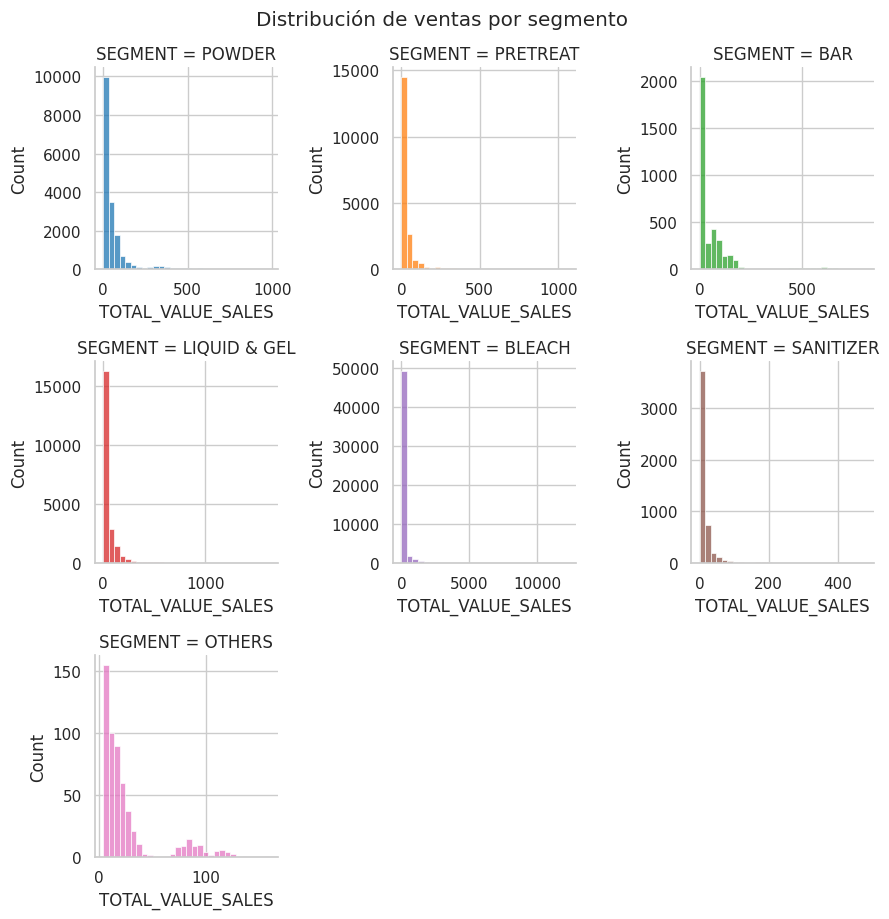

In [16]:
# Paleta de colores para los segmentos
palette = sns.color_palette("tab10", n_colors=df['SEGMENT'].nunique())

segment_colors = dict(zip(df['SEGMENT'].unique(), palette))

# Función para graficar con color según segmento
def colored_hist(data, color, **kwargs):
    segment = data['SEGMENT'].iloc[0]
    sns.histplot(data['TOTAL_VALUE_SALES'], bins=30, color=segment_colors[segment], **kwargs)

# Grafica con FacetGrid y con la función creada
g = sns.FacetGrid(df, col='SEGMENT', col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(colored_hist)
g.fig.suptitle('Distribución de ventas por segmento', y=1.02)
plt.show()

## Tendencia de ventas con respecto al tiempo

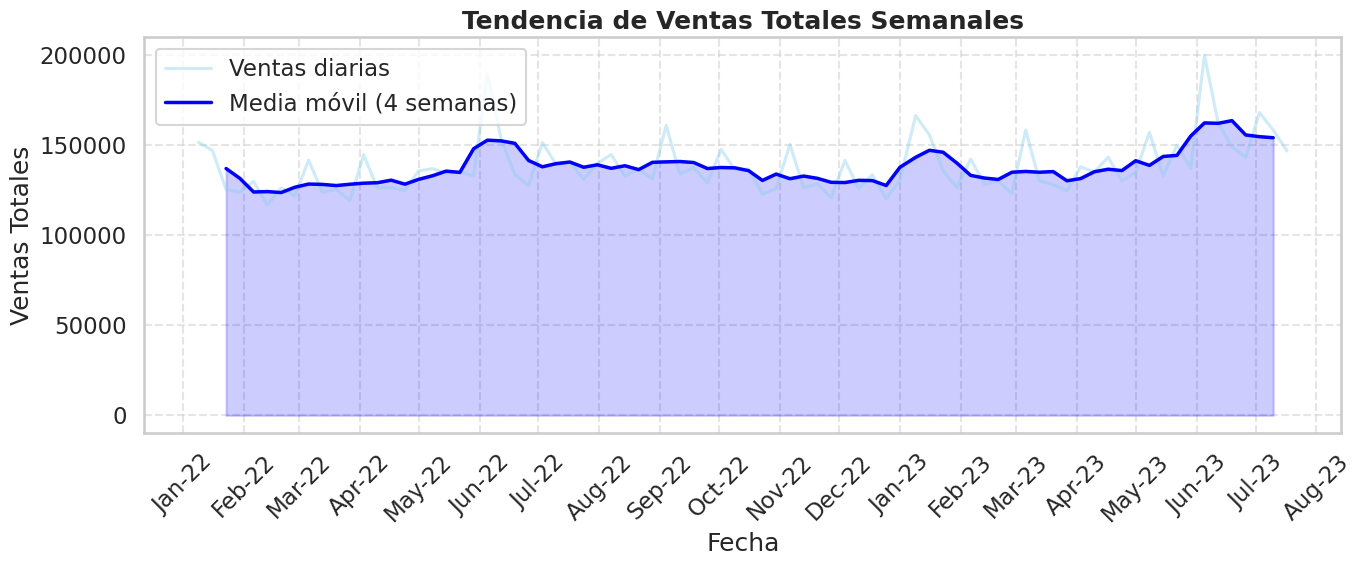

In [17]:
# Estilo de gráficas
sns.set(style="whitegrid", context='talk', palette="deep")

# Agregación por fecha
ventas_diarias = df.groupby('DATE')['TOTAL_SALES'].sum().reset_index()

# Suavizado con media móvil
ventas_diarias['rolling'] = ventas_diarias['TOTAL_SALES'].rolling(window=4, center=True).mean()

# Crear la figura
plt.figure(figsize=(14, 6))
plt.plot(ventas_diarias['DATE'], ventas_diarias['TOTAL_SALES'], color='skyblue', alpha=0.4, label='Ventas diarias')
plt.plot(ventas_diarias['DATE'], ventas_diarias['rolling'], color='blue', linewidth=2.5, label='Media móvil (4 semanas)')
plt.fill_between(ventas_diarias['DATE'], ventas_diarias['rolling'], color='blue', alpha=0.2)

# Mejora en los ejes y formato de fechas
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(rotation=45)

# Títulos y etiquetas
plt.title('Tendencia de Ventas Totales Semanales', fontsize=18, weight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

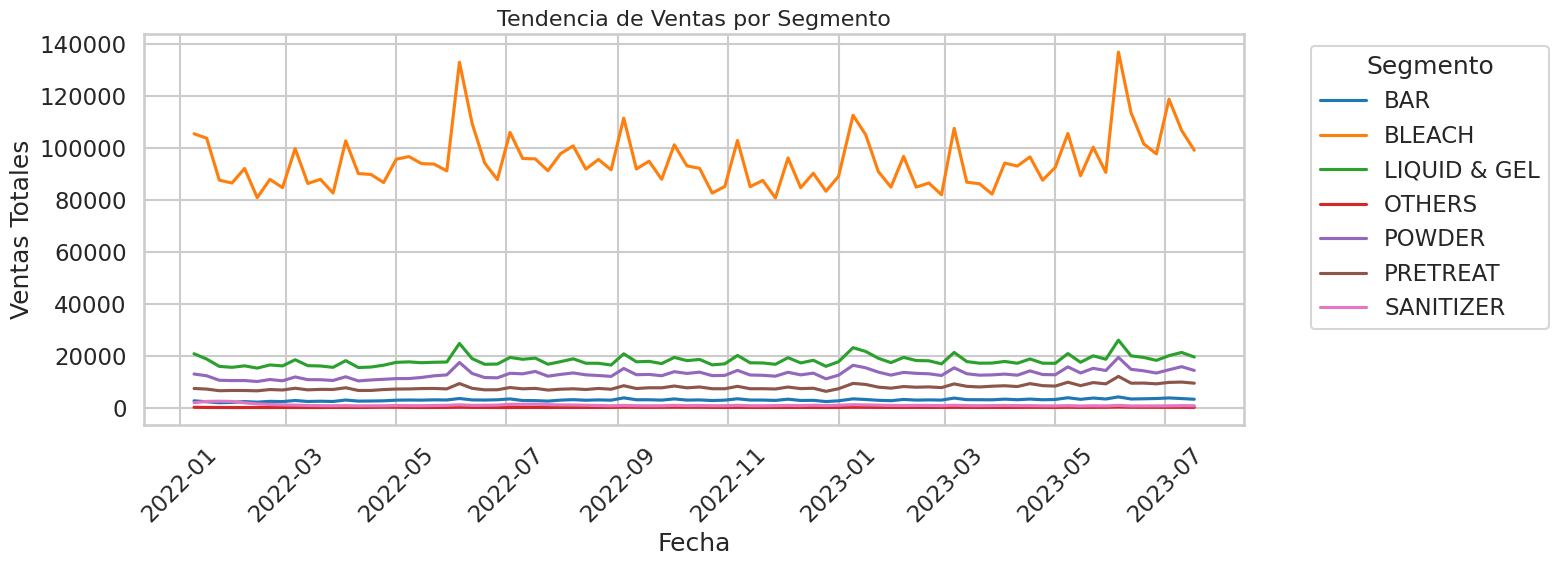

In [18]:
# Agrupar ventas por fecha y segmento
ventas_segmento = df.groupby(['DATE', 'SEGMENT'])['TOTAL_SALES'].sum().reset_index()

plt.figure(figsize=(16, 6))
sns.lineplot(data=ventas_segmento, x='DATE', y='TOTAL_SALES', hue='SEGMENT', palette='tab10')
plt.title('Tendencia de Ventas por Segmento', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales')
plt.legend(title='Segmento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Relación entre diferentes variables

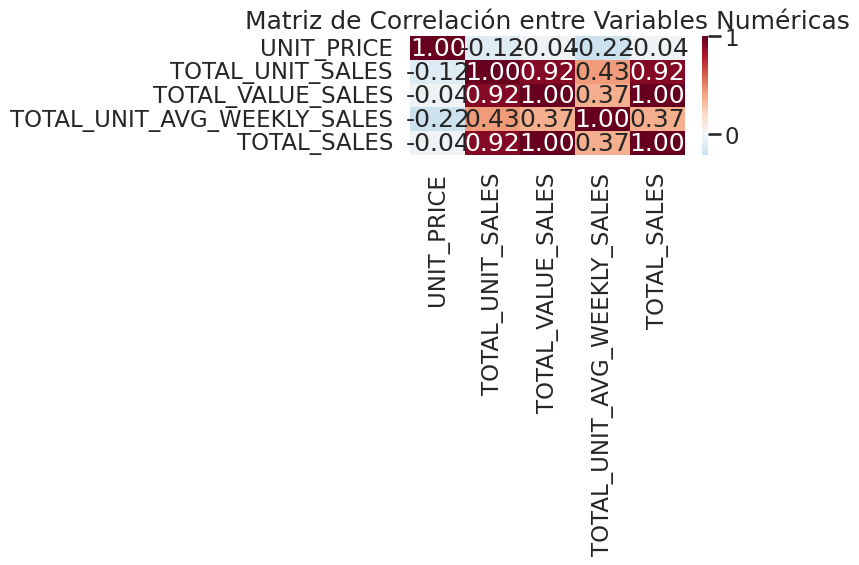

In [19]:
#Matriz de correlación para decidir qué relaciones valen la pena explorar visualmente

# Seleccionar las variables numéricas relevantes
numeric_vars = [
    "UNIT_PRICE",
    "TOTAL_UNIT_SALES",
    "TOTAL_VALUE_SALES",
    "TOTAL_UNIT_AVG_WEEKLY_SALES",
    "TOTAL_SALES"
]

# Calcular la matriz de correlación
corr_matrix = df[numeric_vars].corr()

# Visualizar con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

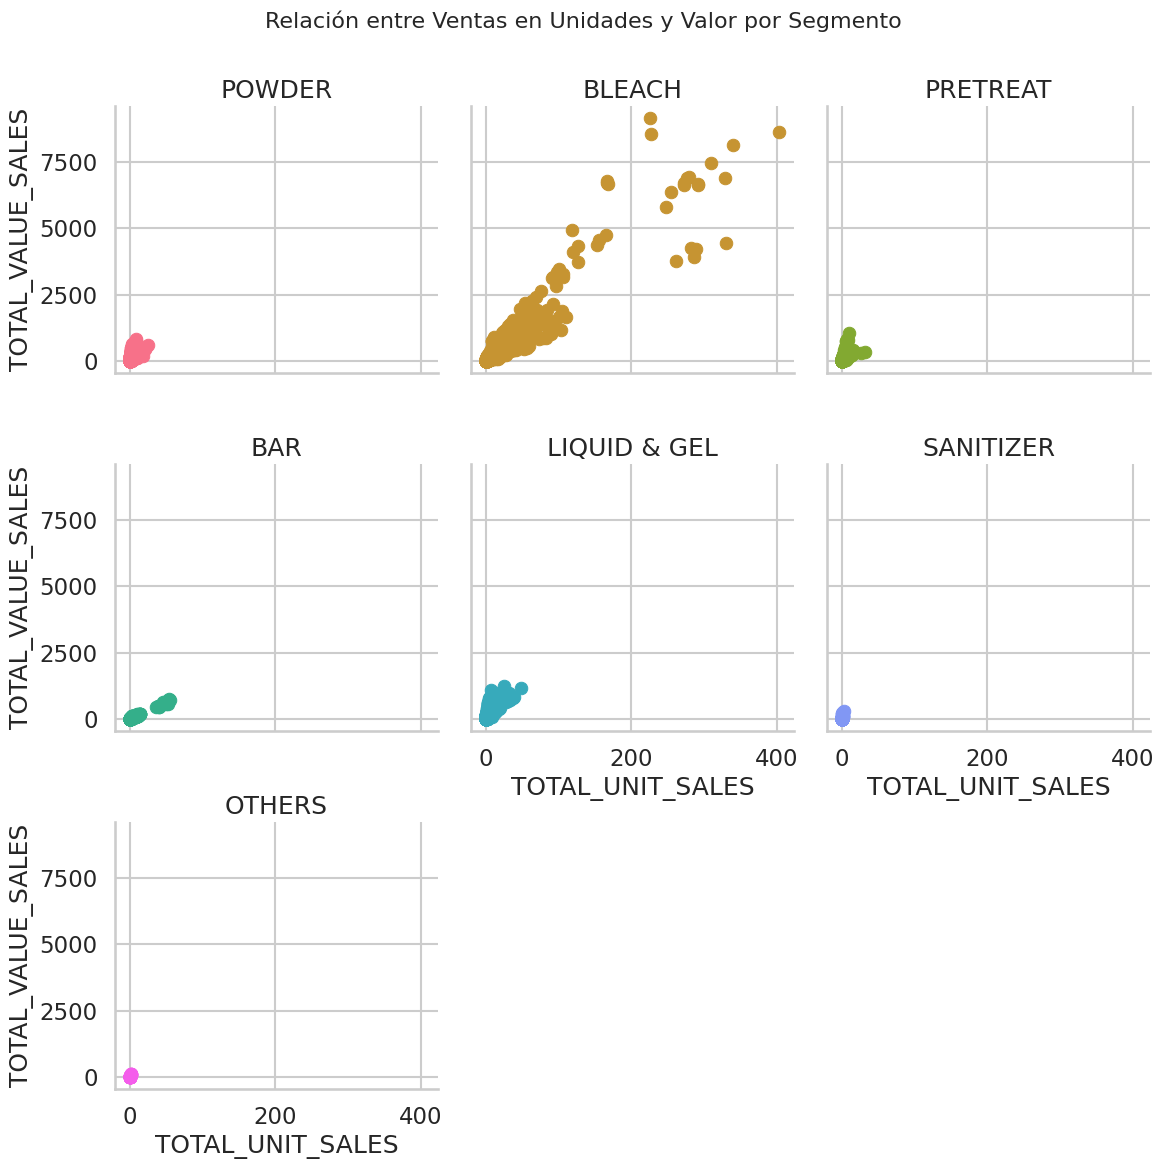

In [20]:
# Paleta personalizada para los segmentos
unique_segments = df["SEGMENT"].unique()
palette = sns.color_palette("husl", len(unique_segments))
segment_color_dict = dict(zip(unique_segments, palette))

# Gráfica con FacetGrid
g = sns.FacetGrid(df.sample(10000), col="SEGMENT", col_wrap=3, height=4)
g.map_dataframe(
    sns.scatterplot,
    x="TOTAL_UNIT_SALES",
    y="TOTAL_VALUE_SALES",
    color=None
)

# Asignar colores individualmente
for ax, segment in zip(g.axes.flat, unique_segments):
    ax.collections[0].set_color(segment_color_dict[segment])

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relación entre Ventas en Unidades y Valor por Segmento", fontsize=16)
plt.show()

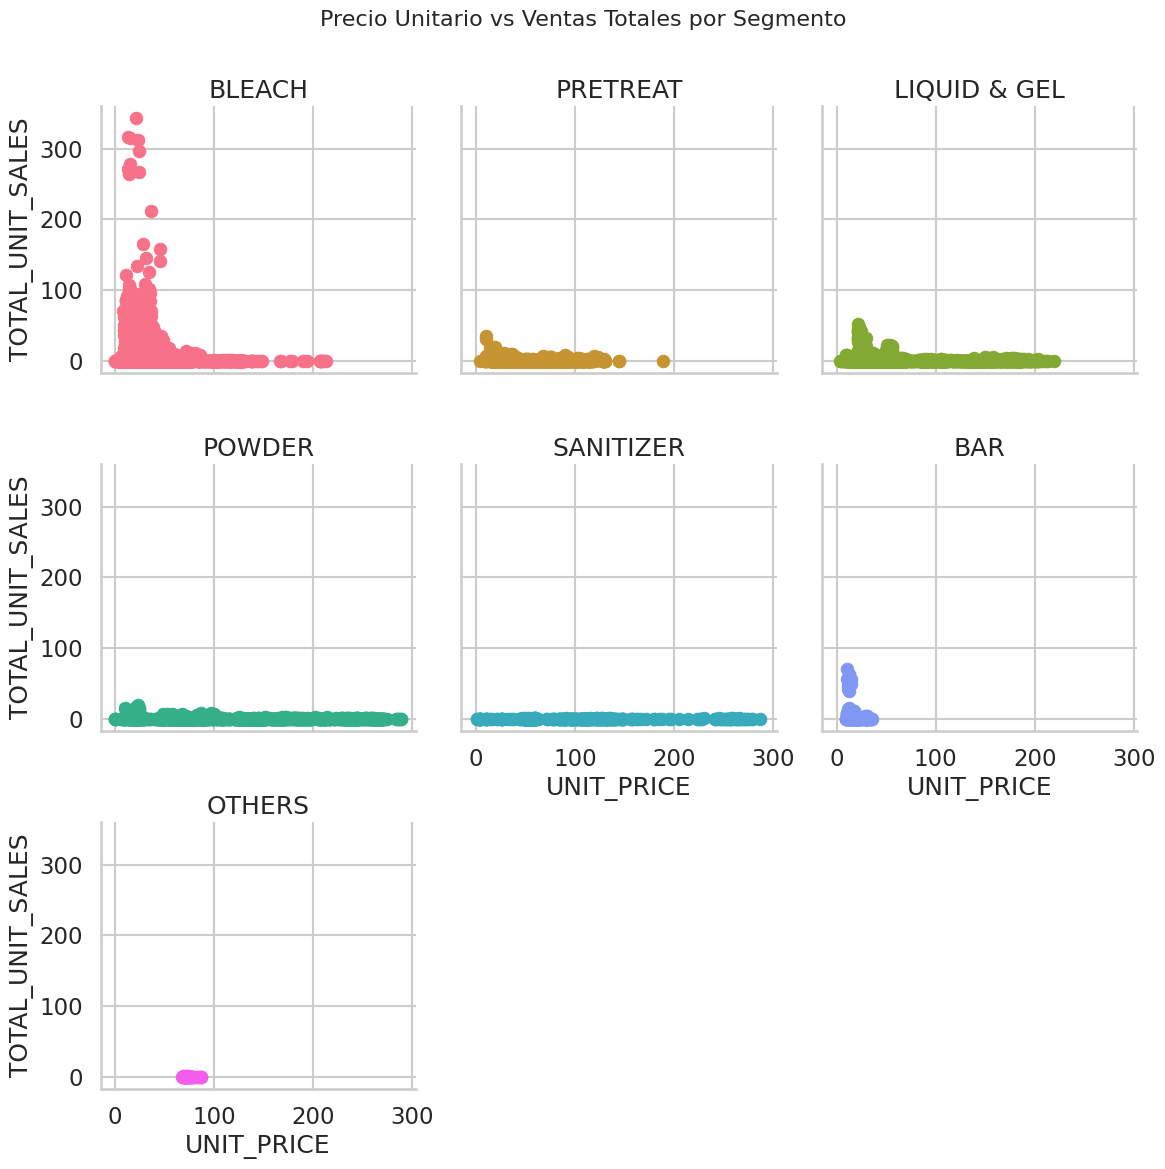

In [21]:
g = sns.FacetGrid(df.sample(10000), col="SEGMENT", col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, x="UNIT_PRICE", y="TOTAL_UNIT_SALES", color=None)

# Aplicar colores por segmento
for ax, segment in zip(g.axes.flat, unique_segments):
    ax.collections[0].set_color(segment_color_dict[segment])

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Precio Unitario vs Ventas Totales por Segmento", fontsize=16)
plt.show()

## Distribución geográfica de las ventas

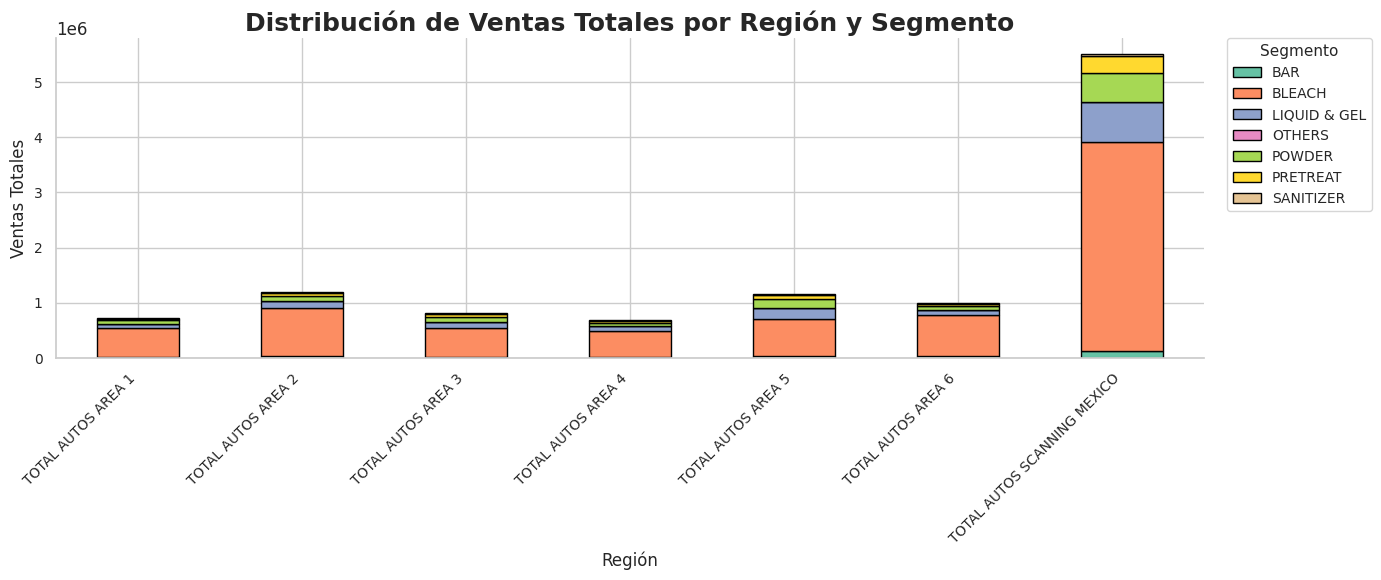

In [22]:
# Configuración de la gráfica
sns.set(style="whitegrid", font_scale=1.1)

# Grupos por región y segmento
region_segment_sales = df.groupby(['REGION', 'SEGMENT'])['TOTAL_SALES'].sum().unstack().fillna(0)

# Colores
colors = sns.color_palette("Set2", n_colors=region_segment_sales.shape[1])

# Gráfico de barras apiladas
ax = region_segment_sales.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=colors,
    edgecolor='black'
)

# Título y etiquetas
plt.title("Distribución de Ventas Totales por Región y Segmento", fontsize=18, fontweight='bold')
plt.ylabel("Ventas Totales", fontsize=12)
plt.xlabel("Región", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Leyenda
plt.legend(title='Segmento', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10, title_fontsize=11)

# Elimina el marco superior y derecho
sns.despine()

# Ajuste de diseño
plt.tight_layout()
plt.show()

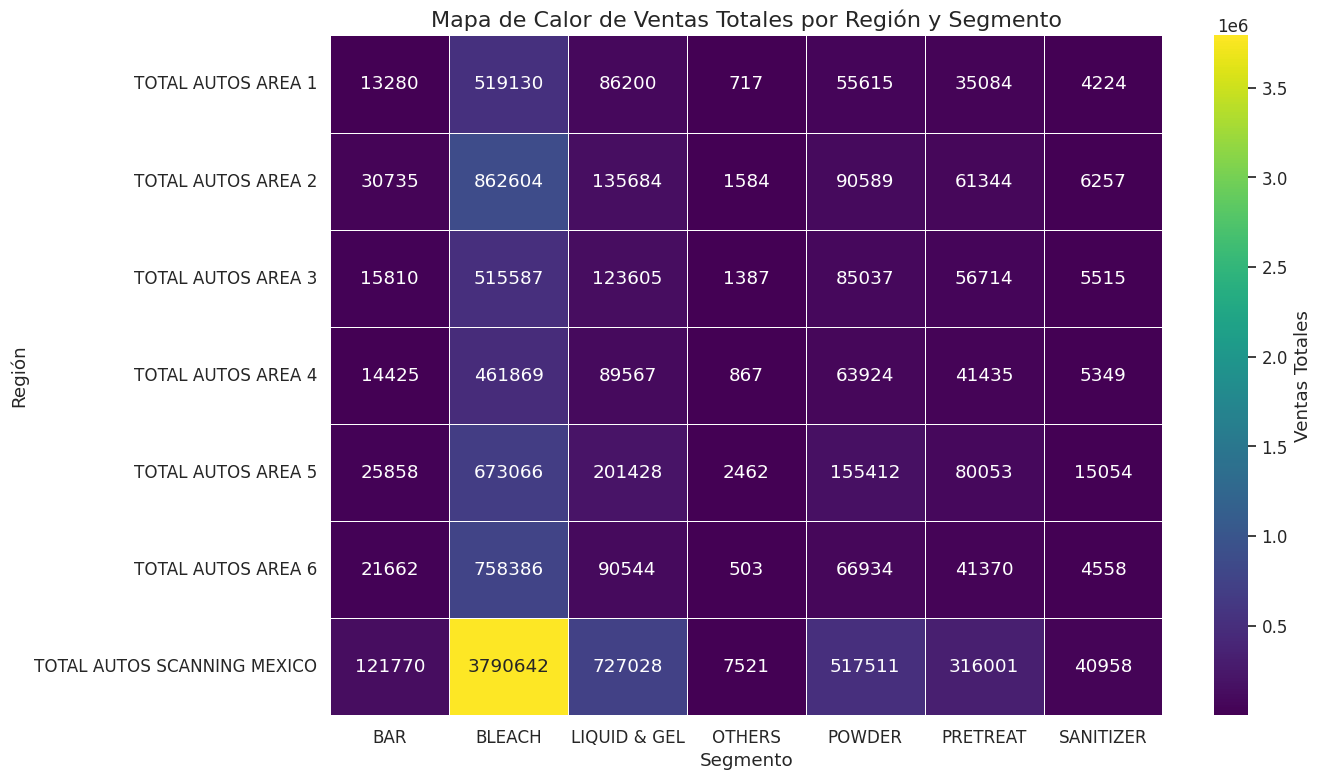

In [23]:
# Grupos por región y segmento
heat_data = df.groupby(['REGION', 'SEGMENT'])['TOTAL_SALES'].sum().unstack().fillna(0)

# Crear mapa de calor
plt.figure(figsize=(14, 8))
sns.heatmap(heat_data, cmap='viridis', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Ventas Totales'})
plt.title("Mapa de Calor de Ventas Totales por Región y Segmento", fontsize=16)
plt.xlabel("Segmento")
plt.ylabel("Región")
plt.tight_layout()
plt.show()

## Outliers y anomalías

### El enfoque será a través de 3 rubros:
* Ventas por Marca
* Ventas por Categoría
* Ventas por Región

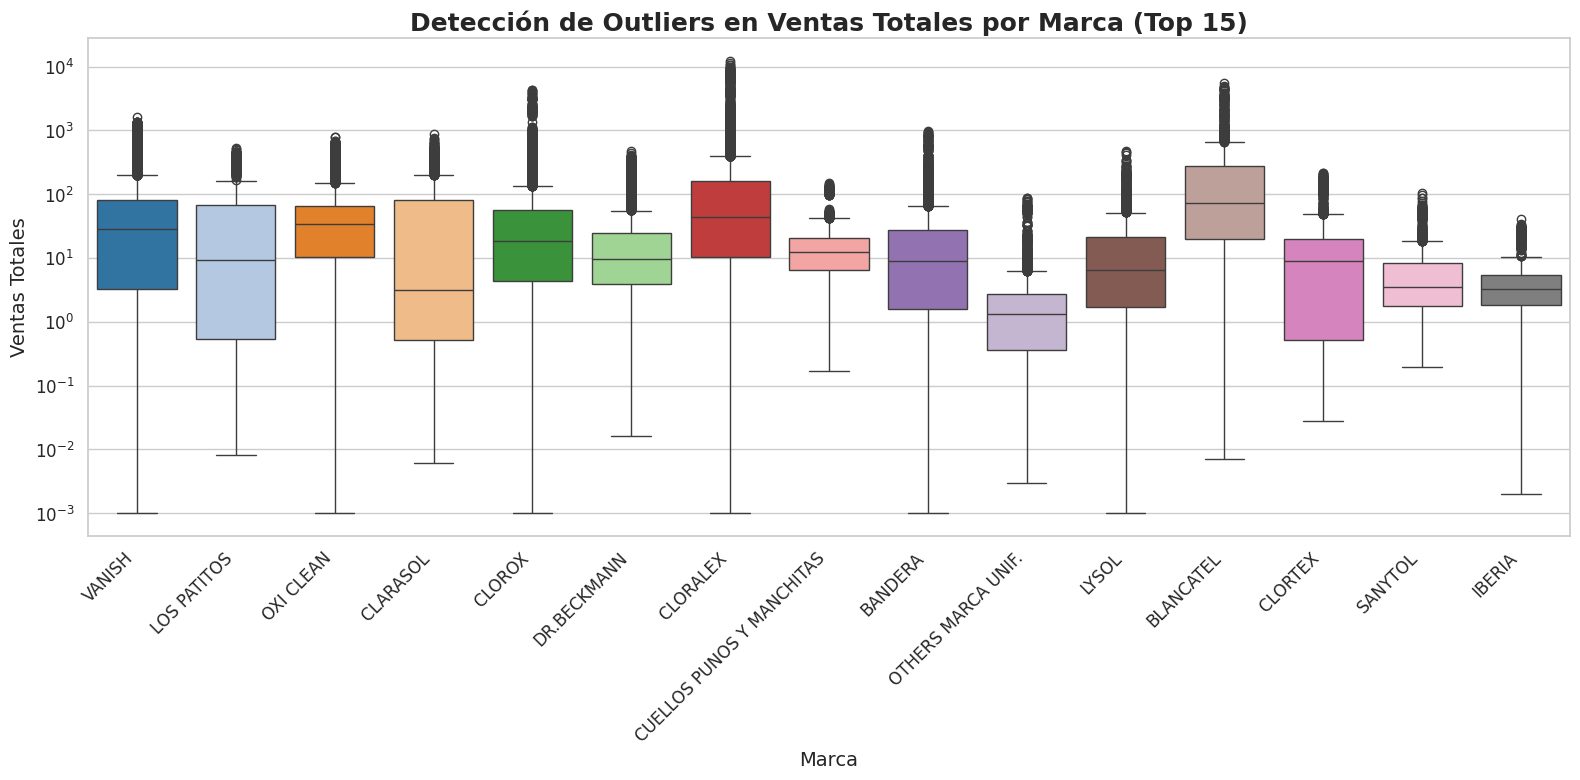

Resumen de Outliers por Marca (Top 15):

CLORTEX: 18.69% outliers (274 de 1466 registros)

CUELLOS PUNOS Y MANCHITAS: 16.14% outliers (142 de 880 registros)

BLANCATEL: 13.48% outliers (285 de 2115 registros)

LOS PATITOS: 13.40% outliers (323 de 2410 registros)

CLARASOL: 12.81% outliers (276 de 2154 registros)

CLORALEX: 12.30% outliers (2821 de 22933 registros)

SANYTOL: 11.67% outliers (196 de 1680 registros)

OTHERS MARCA UNIF.: 11.39% outliers (369 de 3240 registros)

IBERIA: 11.31% outliers (232 de 2052 registros)

CLOROX: 11.20% outliers (2212 de 19754 registros)

BANDERA: 10.79% outliers (1010 de 9361 registros)

DR.BECKMANN: 9.41% outliers (1076 de 11434 registros)

OXI CLEAN: 9.19% outliers (633 de 6889 registros)

LYSOL: 8.96% outliers (309 de 3449 registros)

VANISH: 8.82% outliers (2502 de 28377 registros)

In [24]:
# Ventas por Marca

# Se consideran las marcas con más datos para no saturar la gráfica (15 marcas por ventas)
top_brands = df.groupby('BRAND')['TOTAL_SALES'].sum().sort_values(ascending=False).head(15).index

# Se obtienen los datos de las marcas de productos
df_top_brands = df[df['BRAND'].isin(top_brands)]

# Gráfica
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
palette = sns.color_palette("tab20", len(top_brands))
sns.boxplot(data=df_top_brands, x='BRAND', y='TOTAL_SALES', palette=palette)
plt.title('Detección de Outliers en Ventas Totales por Marca (Top 15)', fontsize=18, fontweight='bold')
plt.xlabel('Marca', fontsize=14)
plt.ylabel('Ventas Totales', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')  # Escala log para mejor visualización
plt.tight_layout()
plt.show()

# Cálculo de outliers para cada marca usando IQR
outliers_summary = []

for brand in top_brands:
    sales = df_top_brands[df_top_brands['BRAND'] == brand]['TOTAL_SALES']
    Q1 = sales.quantile(0.25)
    Q3 = sales.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = sales[(sales < lower_bound) | (sales > upper_bound)].count()
    total_records = sales.count()
    outliers_pct = (outliers_count / total_records) * 100

    outliers_summary.append({
        'BRAND': brand,
        'Total_Records': total_records,
        'Outliers_Count': outliers_count,
        'Outliers_Percentage': outliers_pct
    })

outliers_summary = pd.DataFrame(outliers_summary).sort_values(by='Outliers_Percentage', ascending=False)

# Resumen de outliers con colores
print("\n[bold underline]Resumen de Outliers por Marca (Top 15):[/bold underline]\n")
for _, row in outliers_summary.iterrows():
    brand = row['BRAND']
    pct = row['Outliers_Percentage']
    total = int(row['Total_Records'])
    outliers = int(row['Outliers_Count'])

    if pct >= 15:
        color = "bold red"
    elif pct >= 10:
        color = "yellow"
    elif pct >= 5:
        color = "green"
    else:
        color = "white"

    print(f"[{color}]{brand}[/]: {pct:.2f}% outliers ({outliers} de {total} registros)")

Los productos que presentan mayor variabilidad en las ventas (CLORTEX y CUELLOS PUNOS Y MANCHITAS) podrían representar un riesgo para la empresa, ya que no es posible predecir su demanda y esto podría afectar la planeación de inventarios, la producción y la logística, incrementando el riesgo de sobrestock o faltantes.

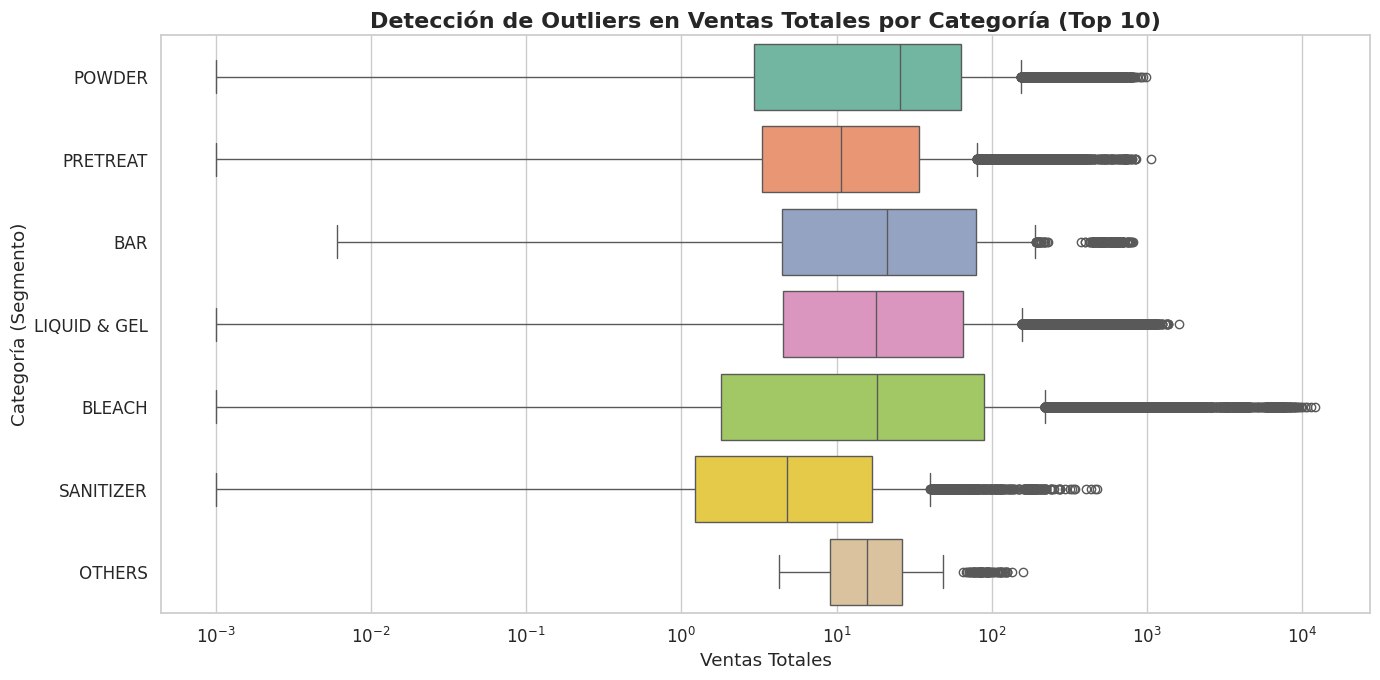

Resumen de Outliers por Categoría:

BLEACH: 12.43% outliers (6618 de 53246 registros)

LIQUID & GEL: 9.42% outliers (2138 de 22697 registros)

POWDER: 8.63% outliers (1527 de 17694 registros)

PRETREAT: 9.24% outliers (1768 de 19143 registros)

BAR: 5.19% outliers (189 de 3639 registros)

SANITIZER: 9.32% outliers (468 de 5023 registros)

OTHERS: 14.46% outliers (81 de 560 registros)

In [25]:
# Ventas por Categoría (Segmento)

# Top 10 categorías (segmentos) por ventas
top_segments = df.groupby('SEGMENT')['TOTAL_SALES'].sum().sort_values(ascending=False).head(10).index
df_top_segments = df[df['SEGMENT'].isin(top_segments)]

# Gráfica
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", len(top_segments))

sns.boxplot(data=df_top_segments, y='SEGMENT', x='TOTAL_SALES', palette=palette, orient='h')
plt.title('Detección de Outliers en Ventas Totales por Categoría (Top 10)', fontsize=16, fontweight='bold')
plt.xlabel('Ventas Totales')
plt.ylabel('Categoría (Segmento)')
plt.xscale('log')  # Escala log para mejor visualización
plt.tight_layout()
plt.show()

# Detección de outliers por Categoría
print("\n[bold underline]Resumen de Outliers por Categoría:[/bold underline]")
outlier_summary = []

for segment in top_segments:
    subset = df_top_segments[df_top_segments['SEGMENT'] == segment]['TOTAL_SALES']
    q1 = subset.quantile(0.25)
    q3 = subset.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = subset[(subset < lower_bound) | (subset > upper_bound)]

    total = subset.count()
    outliers_count = outliers.count()
    outlier_percentage = (outliers_count / total) * 100

    outlier_summary.append({
        'Segment': segment,
        'Total_Records': total,
        'Outliers_Count': outliers_count,
        'Outliers_Percentage': outlier_percentage
    })

    # Mostrar en consola con colores
    if outlier_percentage > 15:
        print(f"[red]{segment}: {outlier_percentage:.2f}% outliers ({outliers_count} de {total} registros)[/red]")
    elif outlier_percentage > 10:
        print(f"[yellow]{segment}: {outlier_percentage:.2f}% outliers ({outliers_count} de {total} registros)[/yellow]")
    else:
        print(f"[green]{segment}: {outlier_percentage:.2f}% outliers ({outliers_count} de {total} registros)[/green]")

En las ventas por segmento, se observa que la mayoría de las categorías opera con estabilidad y sin fluctuaciones extremas que afecten la confiabilidad de los datos. Esto indica que no existen riesgos financieros inmediatos derivados de comportamientos irregulares o anomalías en la mayoría de los segmentos. Sin embargo, algunos segmentos como OTHERS presentan un porcentaje mayor de valores atípicos, lo que sugiere la necesidad de un monitoreo adicional para garantizar la calidad y precisión de la información en estos casos.

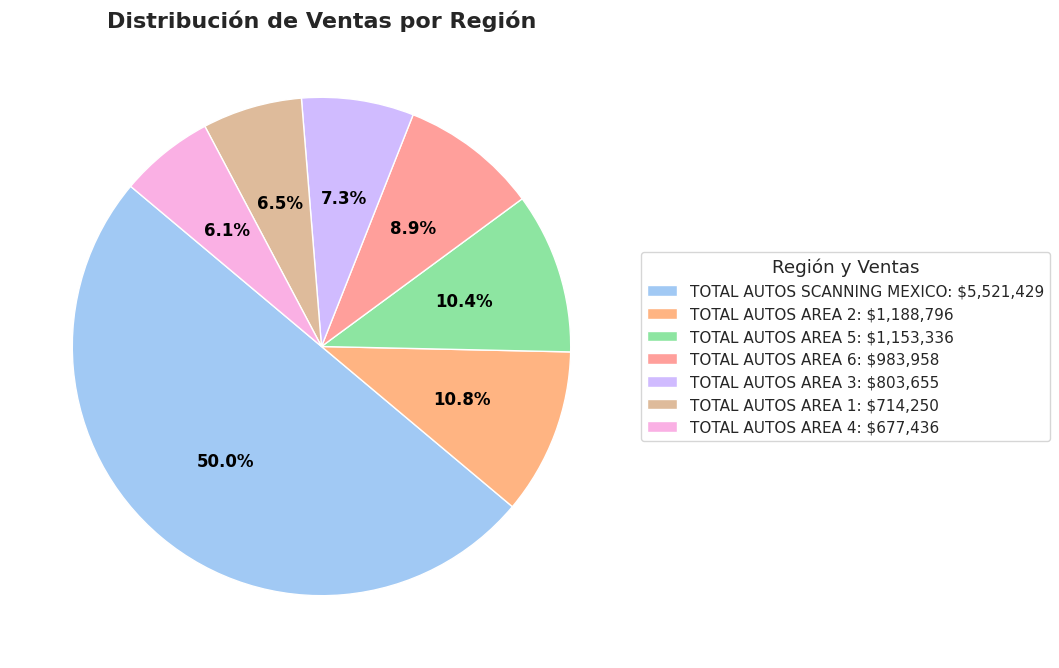

Resumen de Outliers por Región:

TOTAL AUTOS SCANNING MEXICO: 9.68% outliers (2031 de 20990 registros)

TOTAL AUTOS AREA 2: 9.29% outliers (1719 de 18505 registros)

TOTAL AUTOS AREA 5: 8.71% outliers (1406 de 16135 registros)

TOTAL AUTOS AREA 6: 10.16% outliers (1718 de 16913 registros)

TOTAL AUTOS AREA 3: 9.99% outliers (1648 de 16496 registros)

TOTAL AUTOS AREA 1: 7.80% outliers (1231 de 15781 registros)

TOTAL AUTOS AREA 4: 9.02% outliers (1549 de 17182 registros)

In [26]:
# Ventas por Región

region_sales = df.groupby('REGION')['TOTAL_SALES'].sum().sort_values(ascending=False)

# Datos para gráfica de pastel
labels = region_sales.index
sales_values = region_sales.values
percentages = 100 * sales_values / sales_values.sum()
colors = sns.color_palette("pastel")

# Etiquetas externas con nombre y ventas
external_labels = [f"{region}: ${sales:,.0f}" for region, sales in zip(labels, sales_values)]

# Gráfica de pastel
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    sales_values,
    labels=None,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12, 'color': 'black'}
)

# leyenda externa
plt.legend(wedges, external_labels, title="Región y Ventas", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
plt.setp(autotexts, size=12, weight="bold")
plt.title("Distribución de Ventas por Región", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Detección de outliers por región
print("\n[bold underline]Resumen de Outliers por Región:[/bold underline]")

summary = []

for region in labels:
    region_data = df[df['REGION'] == region]['TOTAL_SALES']
    q1 = region_data.quantile(0.25)
    q3 = region_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = region_data[(region_data < lower_bound) | (region_data > upper_bound)]
    total = len(region_data)
    outliers_count = len(outliers)
    percentage = (outliers_count / total) * 100 if total > 0 else 0

    # Clasificación por color
    if percentage > 15:
        color = "red"
    elif percentage > 10:
        color = "yellow"
    else:
        color = "green"

    print(f"[{color}]{region}: {percentage:.2f}% outliers ({outliers_count} de {total} registros)[/{color}]")

    summary.append({
        'REGION': region,
        'Total_Records': total,
        'Outliers_Count': outliers_count,
        'Outliers_Percentage': percentage
    })

El AREA 6 presenta el porcentaje más alto de outliers con 10.16%, lo que sugiere una variabilidad superior al promedio. Aunque no representa un riesgo crítico, es recomendable revisar los casos específicos para descartar errores operativos o identificar patrones de oportunidad. Las demás regiones se encuentran en niveles aceptables, lo cual indica un comportamiento de ventas relativamente estable y sin señales de alerta crítica.

## Resumen de los hallazgos obtenidos
Al revisar las ventas por marca, algunas tienen mucha venta pero también muestran altibajos grandes, lo que podría generar ciertos riesgos y merece atención. Por otro lado, las ventas por segmento son bastante estables, sin cambios bruscos, lo que da confianza en la información. En cuanto a las regiones, aunque las ventas varían, no se observan comportamientos extraños que preocupen. En general, la recomendación es estar pendientes de las marcas con mucha variabilidad, mientras que los segmentos y regiones parecen estar bajo control.

# 4. Segmentación de Productos o Regiones con Clustering
### Objetivo:
- Aplicar K-Means para segmentar productos/regiones
- Determinar el número óptimo de clusters (método del codo)
- Interpretar patrones de rendimiento


In [27]:
# Filtrar por marca Vanish
df_vanish = df[df['BRAND'].str.upper() == 'VANISH'].copy()

# Verificar registros
print(f"Registros filtrados (Vanish): {df_vanish.shape[0]}")
df_vanish.head()

Registros filtrados (Vanish): 28377

,WEEK,ITEM_CODE,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,MANUFACTURER,BRAND,ITEM,ITEM_DESCRIPTION,...,ATTR2,ATTR3,ID_CATEGORY,SEGMENT,YEAR,MONTH,WEEK_NUMBER,DATE,UNIT_PRICE,TOTAL_SALES
0,34-22,7501058792808BP2,0.006,0.139,1.000,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058792808BP2,VANISHOXIACTIONROSADOYPACK120GR+MMCRYSTALWHITE...,...,FABRIC TREATMENT,ROSA,NaN,POWDER,2022,8,34,2022-08-28,23.166667,0.139
1,34-22,7501058715883,0.487,116.519,2.916,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058715883,VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...,...,FABRIC TREATMENT,ROSA,NaN,POWDER,2022,8,34,2022-08-28,239.258727,116.519
2,34-22,7702626213774,1.391,68.453,5.171,TOTAL AUTOS AREA 5,RECKITT,VANISH,7702626213774,VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...,...,FABRIC TREATMENT,ROSA,NaN,POWDER,2022,8,34,2022-08-28,49.211359,68.453
3,34-22,7501058716422,0.022,1.481,1.833,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058716422,VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...,...,FABRIC TREATMENT,ROSA,NaN,POWDER,2022,8,34,2022-08-28,67.318182,1.481
4,34-22,7501058784353,2.037,182.839,5.375,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058784353,VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...,...,FABRIC TREATMENT,ROSA,NaN,POWDER,2022,8,34,2022-08-28,89.758959,182.839


In [28]:
# Agrupar por producto y obtener promedios/relevantes
df_prod = df_vanish.groupby('ITEM_CODE').agg({
    'ITEM_DESCRIPTION': 'first',
    'TOTAL_UNIT_SALES': 'sum',
    'TOTAL_VALUE_SALES': 'sum',
    'UNIT_PRICE': 'mean',
    'CATEGORY': 'first',
    'FORMAT': 'first',
    'REGION': 'nunique',
    'ATTR1': 'first',
    'ATTR2': 'first',
    'ATTR3': 'first'
}).reset_index()

df_prod.head()

,ITEM_CODE,ITEM_DESCRIPTION,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,UNIT_PRICE,CATEGORY,FORMAT,REGION,ATTR1,ATTR2,ATTR3
0,7501058712813,VANISH OXI ACTION QUITAMANCHAS P/ROPA BOTE 240...,0.586,28.885,56.268015,1,POLVO,7,SAFE BLEACH,FABRIC TREATMENT,ROSA
1,7501058713780,VANISH OXI ACTION ROSA QUITA MANCHAS PARA LA R...,0.162,3.580,24.589332,1,POLVO,7,SAFE BLEACH,FABRIC TREATMENT,ROSA
2,7501058714596,VANISH SUPER BARRA QUITA MANCHAS 68GR 75010587...,8059.988,99483.947,12.358560,1,BARRA,7,SAFE BLEACH,FABRIC TREATMENT,ROSA
3,7501058715012,VANISH OXI ACTION CRISTAL WHITE BOT 150GR 7501...,0.118,3.106,26.757729,1,POLVO,7,SAFE BLEACH,FABRIC TREATMENT,BLANCO
4,7501058715029,VANISH MULTIUSOS REMOVEDOR S/CLORO DE MANCHAS ...,0.092,1.784,19.854658,1,LIQUIDO,3,SAFE BLEACH,FABRIC TREATMENT,ROSA


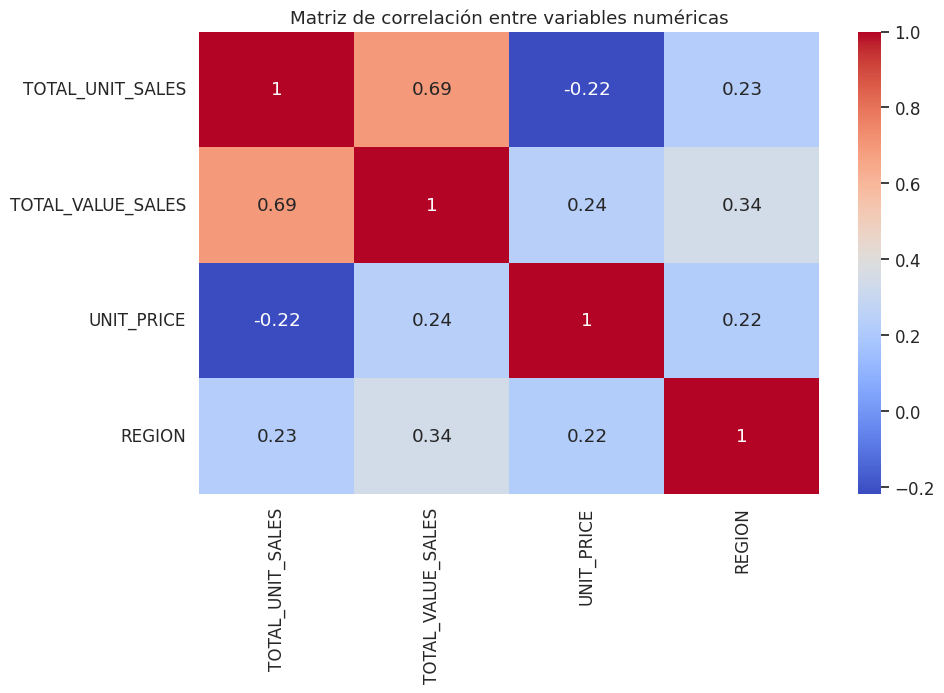

In [29]:
# Preselección de variables

import seaborn as sns
import matplotlib.pyplot as plt


num_cols = ['TOTAL_UNIT_SALES', 'TOTAL_VALUE_SALES', 'UNIT_PRICE', 'REGION']
sns.heatmap(df_prod[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler

# Variables numéricas y categóricas relevantes
features = ['TOTAL_UNIT_SALES', 'TOTAL_VALUE_SALES', 'UNIT_PRICE', 'CATEGORY',
            'FORMAT', 'ATTR1', 'ATTR2', 'ATTR3']

# One-Hot Encoding
df_encoded = pd.get_dummies(df_prod[features], drop_first=True)

# Escalado
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded)

# Guardar como DataFrame para clustering
import numpy as np
df_scaled = pd.DataFrame(scaled_features, columns=df_encoded.columns, index=df_prod['ITEM_CODE'])

df_scaled.head()

,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,UNIT_PRICE,CATEGORY,FORMAT_GEL,FORMAT_LIQUIDO,FORMAT_POLVO,ATTR1_SAFE BLEACH,ATTR3_ROSA
ITEM_CODE,,,,,,,,,
7501058712813,-0.452680,-0.686405,-0.189449,0.0,-0.450694,-0.693375,1.185854,0.163299,0.777282
7501058713780,-0.452948,-0.687022,-0.738152,0.0,-0.450694,-0.693375,1.185854,0.163299,0.777282
7501058714596,4.628397,1.740353,-0.950000,0.0,-0.450694,-0.693375,-0.843274,0.163299,0.777282
7501058715012,-0.452976,-0.687034,-0.700593,0.0,-0.450694,-0.693375,1.185854,0.163299,-1.286535
7501058715029,-0.452992,-0.687066,-0.820161,0.0,-0.450694,1.442221,-0.843274,0.163299,0.777282


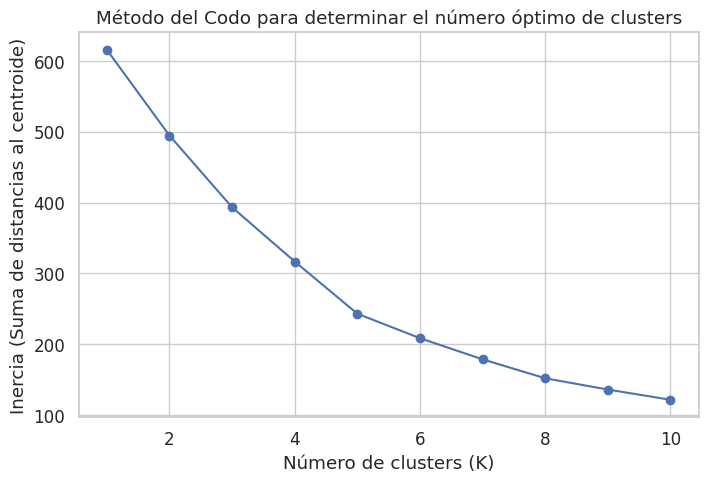

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para guardar la inercia
inertia = []

# Probar con K de 1 a 10
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (Suma de distancias al centroide)')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.grid(True)
plt.show()

In [32]:
from sklearn.cluster import KMeans

# Entrenar modelo con K=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_prod['Cluster'] = kmeans.fit_predict(df_scaled)

# Ver un resumen de los clusters asignados
df_prod[['ITEM_CODE', 'ITEM_DESCRIPTION', 'Cluster']].head()

,ITEM_CODE,ITEM_DESCRIPTION,Cluster
0,7501058712813,VANISH OXI ACTION QUITAMANCHAS P/ROPA BOTE 240...,2
1,7501058713780,VANISH OXI ACTION ROSA QUITA MANCHAS PARA LA R...,2
2,7501058714596,VANISH SUPER BARRA QUITA MANCHAS 68GR 75010587...,0
3,7501058715012,VANISH OXI ACTION CRISTAL WHITE BOT 150GR 7501...,2
4,7501058715029,VANISH MULTIUSOS REMOVEDOR S/CLORO DE MANCHAS ...,1


In [33]:
# Estadísticas generales por cluster
cluster_summary = df_prod.groupby('Cluster').agg({
    'TOTAL_UNIT_SALES': ['mean', 'sum', 'count'],
    'TOTAL_VALUE_SALES': ['mean', 'sum'],
    'UNIT_PRICE': 'mean'
}).round(2)

cluster_summary.columns = ['_'.join(col) for col in cluster_summary.columns]
cluster_summary

,TOTAL_UNIT_SALES_mean,TOTAL_UNIT_SALES_sum,TOTAL_UNIT_SALES_count,TOTAL_VALUE_SALES_mean,TOTAL_VALUE_SALES_sum,UNIT_PRICE_mean
Cluster,,,,,,
0,6011.31,30056.54,5,124388.15,621940.74,25.24
1,351.01,9477.20,27,20230.50,546223.61,59.68
2,407.80,13049.58,32,22168.06,709377.89,75.30
3,284.78,569.56,2,27122.88,54245.76,93.13
4,198.19,2180.07,11,21500.14,236501.53,76.49


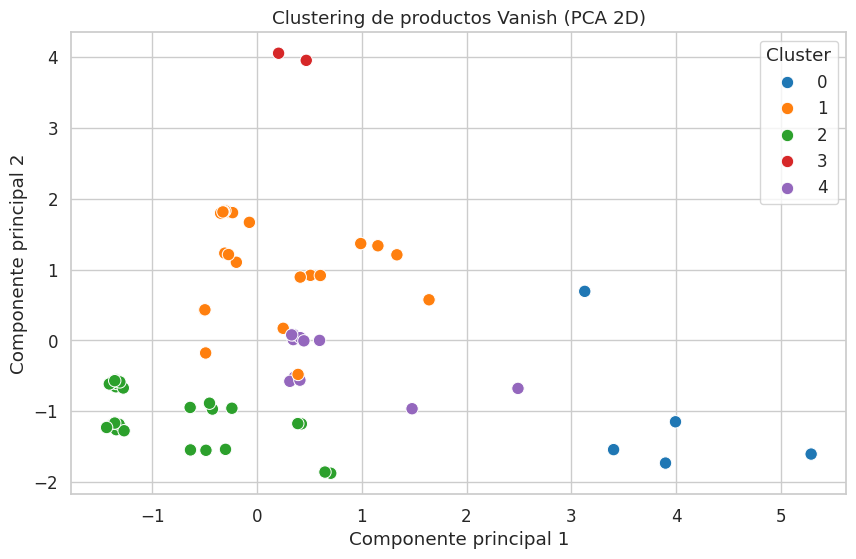

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 componentes
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled)

# Crear DataFrame para visualizar
df_vis = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_vis['Cluster'] = df_prod['Cluster'].values
df_vis['ITEM_DESCRIPTION'] = df_prod['ITEM_DESCRIPTION'].values

# Gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=80)
plt.title('Clustering de productos Vanish (PCA 2D)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [35]:
pd.crosstab(df_prod['Cluster'], df_prod['FORMAT'])
pd.crosstab(df_prod['Cluster'], df_prod['ATTR3'])

ATTR3,BLANCO,ROSA
Cluster,,
0,2,3
1,9,18
2,14,18
3,0,2
4,4,7


## Análisis
El grupo 0 representa a los productos con mayores volúmenes de venta y un precio accesible, convirtiéndose en el segmento más rentable. El grupo 2, aunque con un precio más elevado, también alcanza un valor total significativo, consolidándose como una línea premium con buen desempeño. El grupo 1 reúne productos de precio medio-alto y desempeño aceptable. El grupo 4 presenta bajo volumen de ventas, con precios altos, lo cual podría indicar bajo rendimiento o escasa demanda. Finalmente, el grupo 3, con sólo dos productos, muestra precios elevados y muy bajo volumen, lo que sugiere un nicho muy específico o productos poco competitivos.

# 5. Análisis de Datos con SQL en SQLite

### Objetivo:
- Integrar los datos de ventas y dimensiones en una base de datos SQLite
- Ejecutar consultas clave para obtener insights sobre ventas por categoría, segmento y productos específicos
- Visualizar resultados para facilitar la interpretación

In [35]:
# Crear/conectar a la base de datos SQLite
conn = sqlite3.connect('VentasReckittDB.db')
cursor = conn.cursor()

## Creación y llenado de las tablas en la base de datos

In [51]:
cursor = conn.cursor()

# Crear tabla DIM_CATEGORY
cursor.execute("""
CREATE TABLE IF NOT EXISTS DIM_CATEGORY (
    ID_CATEGORY INTEGER PRIMARY KEY,
    CATEGORY TEXT
);
""")
conn.commit()

# Verificar creación
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tablas en la base:", tables)

# Insertar datos desde DataFrame
df_category.to_sql("DIM_CATEGORY", conn, if_exists="replace", index=False)

# Verificar primeros registros
df_check = pd.read_sql_query("SELECT * FROM DIM_CATEGORY LIMIT 5;", conn)
print(df_check)

Tablas en la base:            name
0  DIM_CALENDAR
1   DIM_SEGMENT
2    FACT_SALES
3   DIM_PRODUCT
4  DIM_CATEGORY

ID_CATEGORY                    CATEGORY
0            1  FABRIC TREATMENT and SANIT
1            2                    AIR CARE
2            3                LAVAVAJILLAS
3            4            MEGA SUPERFICIES
4            5         LAVATORY CARE & BRC

In [52]:
# Crear tabla DIM_PRODUCT
cursor.execute("""
CREATE TABLE IF NOT EXISTS DIM_PRODUCT (
    ITEM TEXT PRIMARY KEY,
    ITEM_DESCRIPTION TEXT,
    CATEGORY INTEGER,
    BRAND TEXT,
    MANUFACTURER TEXT,
    FORMAT TEXT,
    ATTR1 TEXT,
    ATTR2 TEXT,
    ATTR3 TEXT,
    FOREIGN KEY (CATEGORY) REFERENCES DIM_CATEGORY(ID_CATEGORY)
);
""")
conn.commit()

# Limpiar df_product
for col in ['MANUFACTURER','BRAND','ITEM','ITEM_DESCRIPTION','FORMAT','ATTR1','ATTR2','ATTR3']:
    df_product[col] = df_product[col].astype(str).str.strip()

df_product['CATEGORY'] = pd.to_numeric(df_product['CATEGORY'], errors='coerce')

# Guardar en SQLite
df_product.to_sql("DIM_PRODUCT", conn, if_exists="replace", index=False)

# Verificar primeros registros
df_check = pd.read_sql_query("SELECT * FROM DIM_PRODUCT LIMIT 5;", conn)
print(df_check)

MANUFACTURER     BRAND           ITEM  \
0   INDS. ALEN  CLORALEX  0000075000592   
1   INDS. ALEN  CLORALEX  0000075000608   
2   INDS. ALEN  CLORALEX  0000075000615   
3   INDS. ALEN  CLORALEX  0000075000622   
4   INDS. ALEN  CLORALEX  0000075000639   

                                    ITEM_DESCRIPTION  CATEGORY   FORMAT  \
0  CLORALEX EL RENDIDOR BOT.PLAST. 250ML NAL. 000...         1  LIQUIDO   
1  CLORALEX EL RENDIDOR BOT.PLAST. 500ML NAL. 000...         1  LIQUIDO   
2  CLORALEX EL RENDIDOR BOT.PLAST. 950ML NAL. 000...         1  LIQUIDO   
3  CLORALEX EL RENDIDOR BOT.PLAST. 2000ML NAL 000...         1  LIQUIDO   
4  CLORALEX EL RENDIDOR BOT.PLAST. 3750ML NAL 000...         1  LIQUIDO   

   ATTR1  ATTR2        ATTR3  
0  CLORO  CLORO  NO DEFINIDO  
1  CLORO  CLORO  NO DEFINIDO  
2  CLORO  CLORO  NO DEFINIDO  
3  CLORO  CLORO  NO DEFINIDO  
4  CLORO  CLORO  NO DEFINIDO

In [53]:
# Crear DIM_CALENDAR
cursor.execute("""
CREATE TABLE IF NOT EXISTS DIM_CALENDAR (
    WEEK TEXT PRIMARY KEY,
    YEAR INTEGER,
    MONTH INTEGER,
    WEEK_NUMBER INTEGER,
    DATE DATE
);
""")
conn.commit()

# Limpiar df_calendar
df_calendar['YEAR'] = df_calendar['YEAR'].astype(int)
df_calendar['MONTH'] = df_calendar['MONTH'].astype(int)
df_calendar['WEEK_NUMBER'] = df_calendar['WEEK_NUMBER'].astype(int)
df_calendar['DATE'] = pd.to_datetime(df_calendar['DATE'], errors='coerce')

# Guardar en SQLite
df_calendar.to_sql("DIM_CALENDAR", conn, if_exists="replace", index=False)

# Verificar primeros registros
df_check = pd.read_sql_query("SELECT * FROM DIM_CALENDAR LIMIT 5;", conn)
print(df_check)

WEEK  YEAR  MONTH  WEEK_NUMBER                 DATE
0  01-21  2021      1            1  2021-01-10 00:00:00
1  02-21  2021      1            2  2021-01-17 00:00:00
2  03-21  2021      1            3  2021-01-24 00:00:00
3  04-21  2021      1            4  2021-01-31 00:00:00
4  05-21  2021      2            5  2021-02-07 00:00:00

In [54]:
# Crear DIM_SEGMENT
cursor.execute("""
CREATE TABLE IF NOT EXISTS DIM_SEGMENT (
    CATEGORY INTEGER,
    ATTR1 TEXT,
    ATTR2 TEXT,
    ATTR3 TEXT,
    FORMAT TEXT,
    SEGMENT TEXT
);
""")
conn.commit()

# Limpiar df_segment
for col in ['ATTR1','ATTR2','ATTR3','FORMAT','SEGMENT']:
    df_segment[col] = df_segment[col].astype(str).str.strip()

df_segment['CATEGORY'] = pd.to_numeric(df_segment['CATEGORY'], errors='coerce')

# Guardar en SQLite
df_segment.to_sql("DIM_SEGMENT", conn, if_exists="replace", index=False)

# Verificar primeros registros
df_check = pd.read_sql_query("SELECT * FROM DIM_SEGMENT LIMIT 5;", conn)
print(df_check)

CATEGORY  ATTR1  ATTR2      ATTR3   FORMAT SEGMENT
0         1  CLORO  CLORO    BAMBINO  LIQUIDO  BLEACH
1         1  CLORO  CLORO  GERMICIDA  LIQUIDO  BLEACH
2         1  CLORO  CLORO   MASCOTAS  LIQUIDO  BLEACH
3         1  CLORO  CLORO  MULTIUSOS      GEL  BLEACH
4         1  CLORO  CLORO  MULTIUSOS  LIQUIDO  BLEACH

In [55]:
# Crear FACT_SALES
cursor.execute("""
CREATE TABLE IF NOT EXISTS FACT_SALES (
    WEEK TEXT,
    ITEM_CODE TEXT,
    TOTAL_UNIT_SALES REAL,
    TOTAL_VALUE_SALES REAL,
    TOTAL_UNIT_AVG_WEEKLY_SALES REAL,
    REGION TEXT
);
""")
conn.commit()

In [56]:
# Asegurar que columnas numéricas sean float
for col in ['TOTAL_UNIT_SALES','TOTAL_VALUE_SALES','TOTAL_UNIT_AVG_WEEKLY_SALES']:
    df_sales[col] = pd.to_numeric(df_sales[col], errors='coerce')

# Limpiar texto
df_sales['REGION'] = df_sales['REGION'].astype(str).str.strip()
df_sales['ITEM_CODE'] = df_sales['ITEM_CODE'].astype(str).str.strip()

# Eliminar duplicados
df_sales.drop_duplicates(inplace=True)

In [57]:
df_sales.to_sql("FACT_SALES", conn, if_exists="replace", index=False)

# Revisar primeros registros
df_check = pd.read_sql_query("SELECT * FROM FACT_SALES LIMIT 5;", conn)
print(df_check)

WEEK         ITEM_CODE  TOTAL_UNIT_SALES  TOTAL_VALUE_SALES  \
0  34-22  7501058792808BP2             0.006              0.139   
1  34-22     7501058715883             0.487            116.519   
2  34-22     7702626213774             1.391             68.453   
3  34-22     7501058716422             0.022              1.481   
4  34-22     7501058784353             2.037            182.839   

   TOTAL_UNIT_AVG_WEEKLY_SALES              REGION  
0                        1.000  TOTAL AUTOS AREA 5  
1                        2.916  TOTAL AUTOS AREA 5  
2                        5.171  TOTAL AUTOS AREA 5  
3                        1.833  TOTAL AUTOS AREA 5  
4                        5.375  TOTAL AUTOS AREA 5

## JOINS de las tablas para generar la información consolidada y algunas visualizaciones

In [58]:
query = """
SELECT
    P.ITEM_DESCRIPTION AS Producto,
    F.REGION AS Region,
    CAL.YEAR,
    CAL.MONTH,
    SUM(F.TOTAL_UNIT_SALES) AS TotalUnidadesVendidas,
    SUM(F.TOTAL_VALUE_SALES) AS TotalVentasValor
FROM FACT_SALES F
INNER JOIN DIM_PRODUCT P ON F.ITEM_CODE = P.ITEM
INNER JOIN DIM_CALENDAR CAL ON F.WEEK = CAL.WEEK
GROUP BY
    P.ITEM_DESCRIPTION, F.REGION, CAL.YEAR, CAL.MONTH
ORDER BY
    CAL.YEAR, CAL.MONTH, F.REGION;
"""

df_ventas = pd.read_sql_query(query, conn)
df_ventas.head()

,Producto,Region,YEAR,MONTH,TotalUnidadesVendidas,TotalVentasValor
0,9TIDE LIPIADOR DE ROPA QUITAMANCHAS PLUMON 10 ...,TOTAL AUTOS AREA 1,2022,1,0.223,20.029
1,B'CLORHADA BLANQ CONC BOT 960 ML+MM CLORO+DET ...,TOTAL AUTOS AREA 1,2022,1,3.680,23.196
2,B'CLORHADA BLANQ CONCENT BOT 960 ML+MM CLORO G...,TOTAL AUTOS AREA 1,2022,1,1.945,12.758
3,B'CLORHADA CLORO EN GEL + DETERGENTE FLORAL BO...,TOTAL AUTOS AREA 1,2022,1,0.077,0.967
4,B'CLORHADA CLORO EN GEL+ DETERGENTE FLORAL BP ...,TOTAL AUTOS AREA 1,2022,1,0.903,12.689


## Ventas totales por región

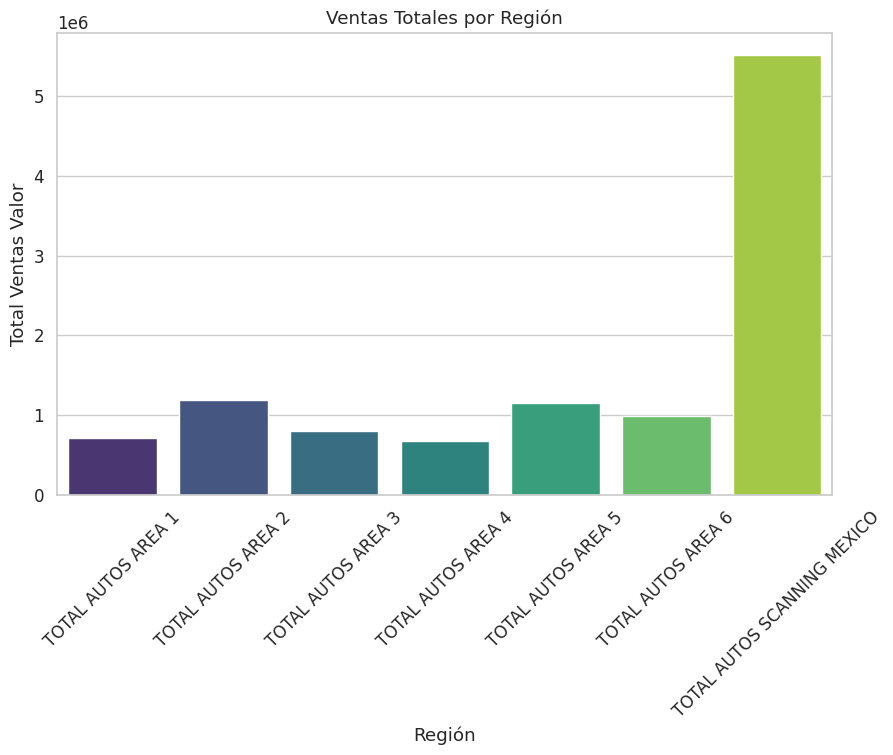

In [59]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_ventas.groupby('Region')['TotalVentasValor'].sum().reset_index(),
            x='Region', y='TotalVentasValor', palette='viridis')
plt.title('Ventas Totales por Región')
plt.xticks(rotation=45)
plt.ylabel('Total Ventas Valor')
plt.xlabel('Región')
plt.show()

## Tendencia mensual de ventas

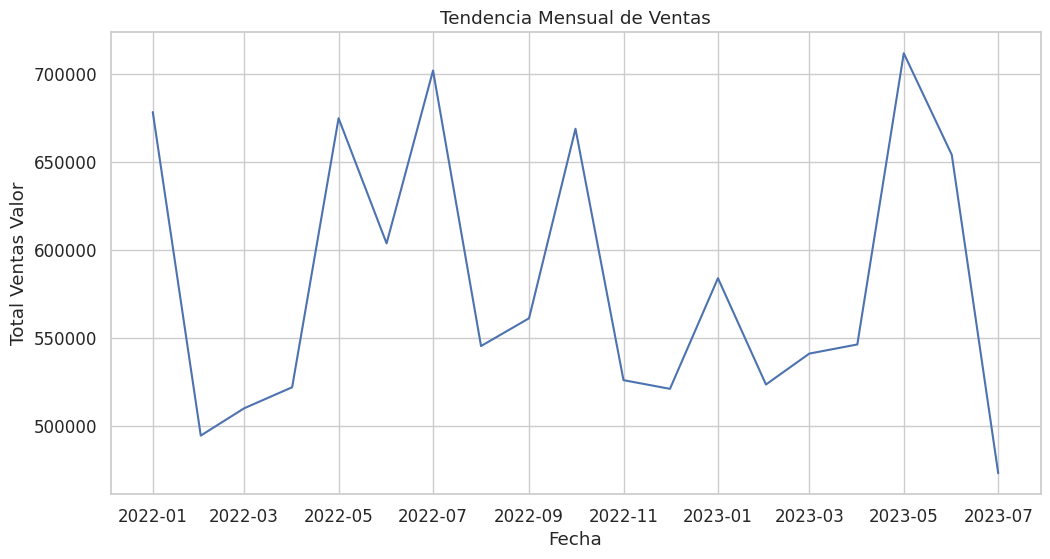

In [60]:
plt.figure(figsize=(12,6))
df_trend = df_ventas.groupby(['YEAR','MONTH'])['TotalVentasValor'].sum().reset_index()
df_trend['Fecha'] = pd.to_datetime(df_trend[['YEAR','MONTH']].assign(DAY=1))
sns.lineplot(data=df_trend, x='Fecha', y='TotalVentasValor')
plt.title('Tendencia Mensual de Ventas')
plt.ylabel('Total Ventas Valor')
plt.xlabel('Fecha')
plt.show()

# 6. Creación de un Dashboard en PowerBI

-------------------------------------------------------------------------------------------------------------------

Menú principal

-------------------------------------------------------------------------------------------------------------------

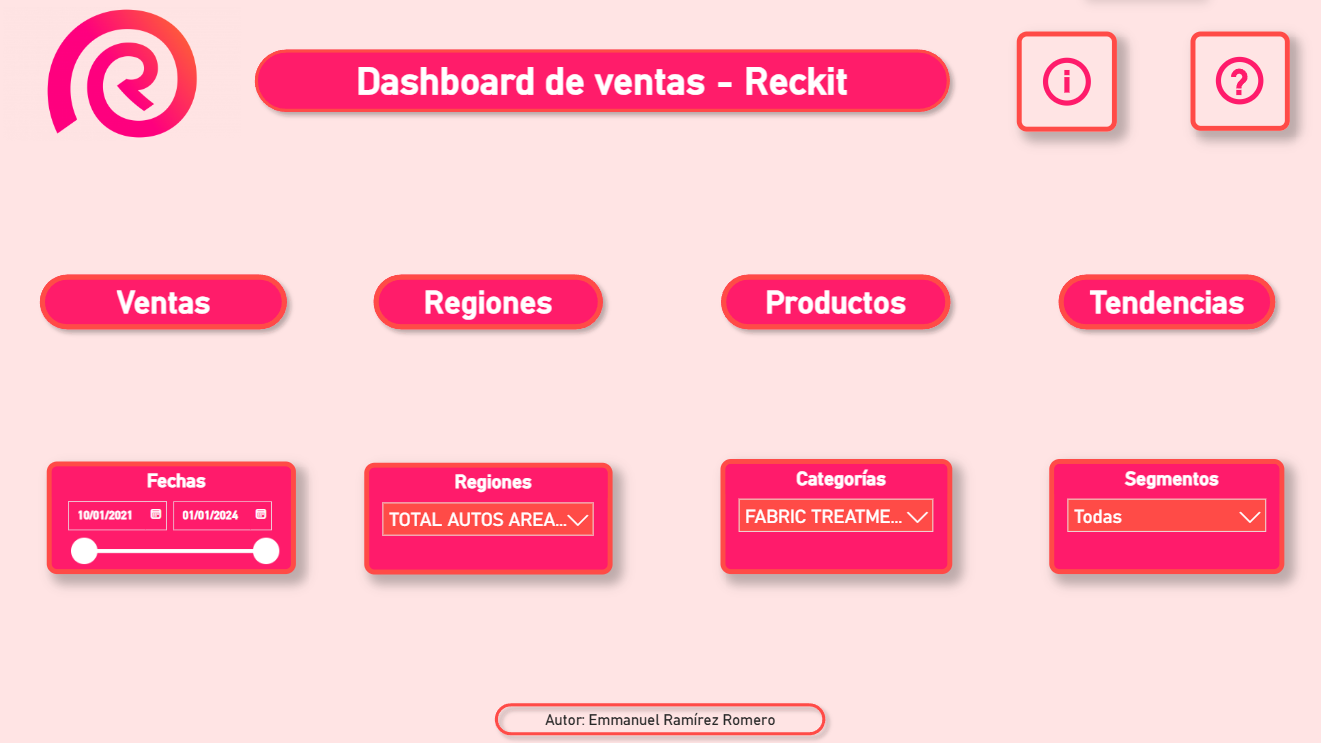

-------------------------------------------------------------------------------------------------------------------

Ventas totales

-------------------------------------------------------------------------------------------------------------------

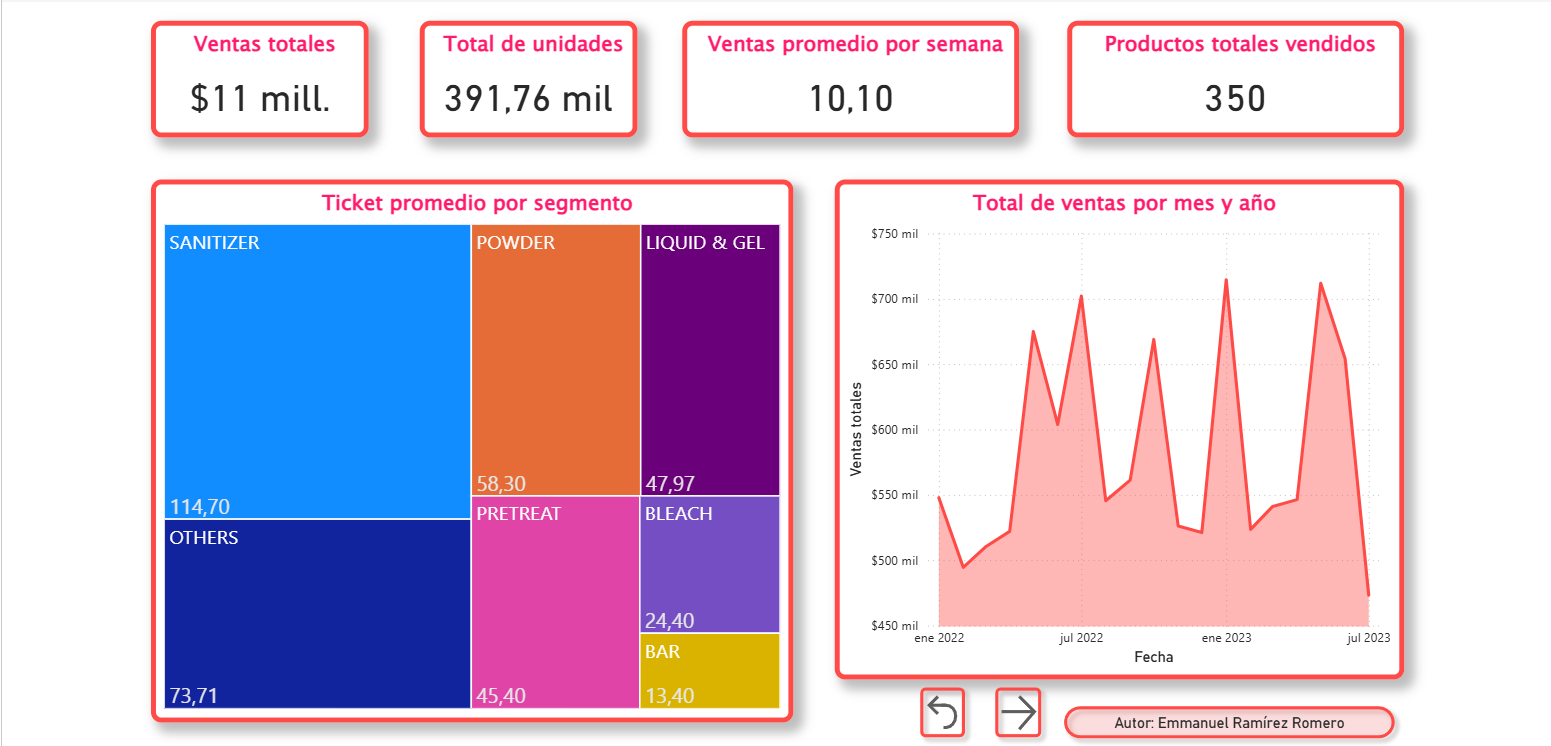

-------------------------------------------------------------------------------------------------------------------

Ventas por Región

-------------------------------------------------------------------------------------------------------------------

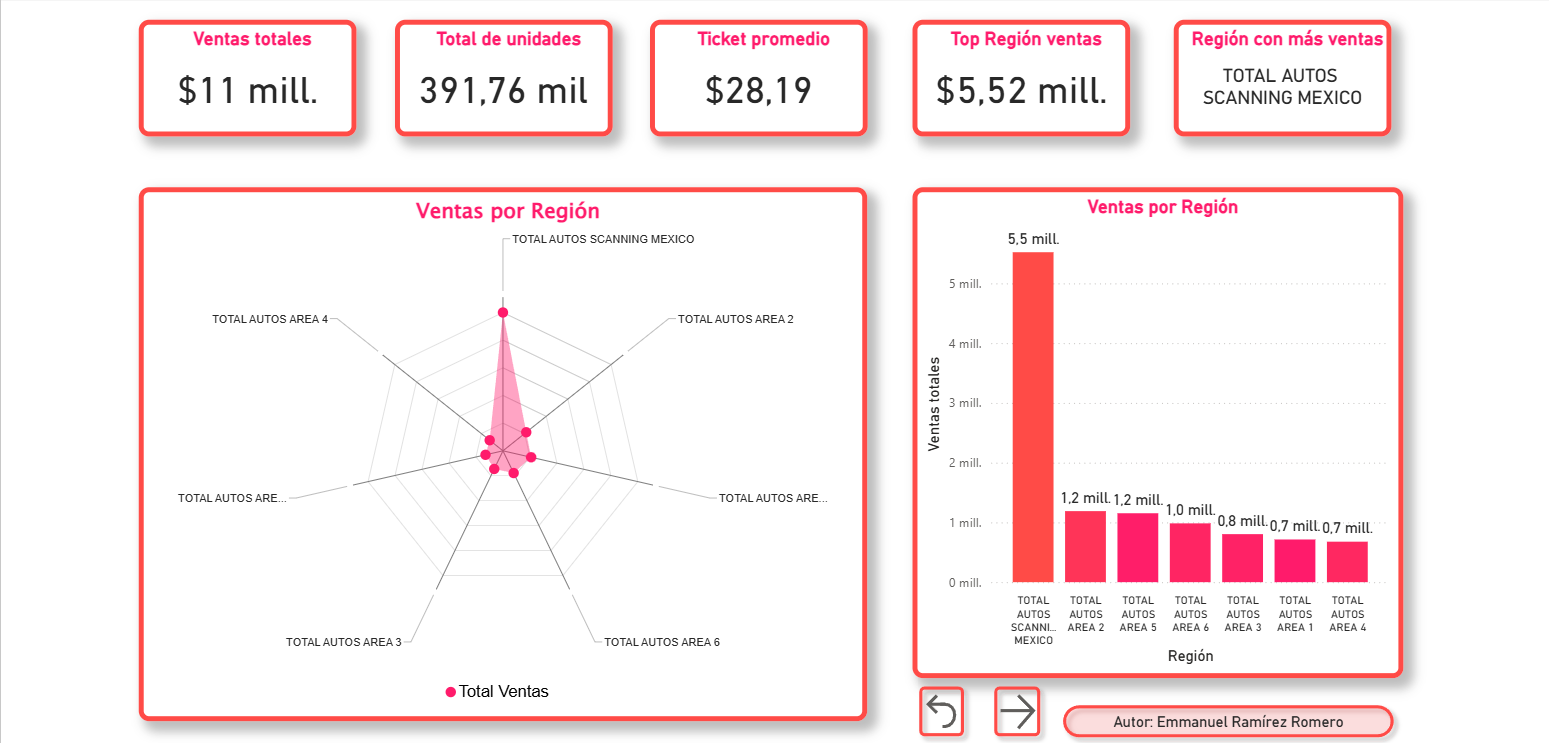

-------------------------------------------------------------------------------------------------------------------

Ventas por Producto

-------------------------------------------------------------------------------------------------------------------

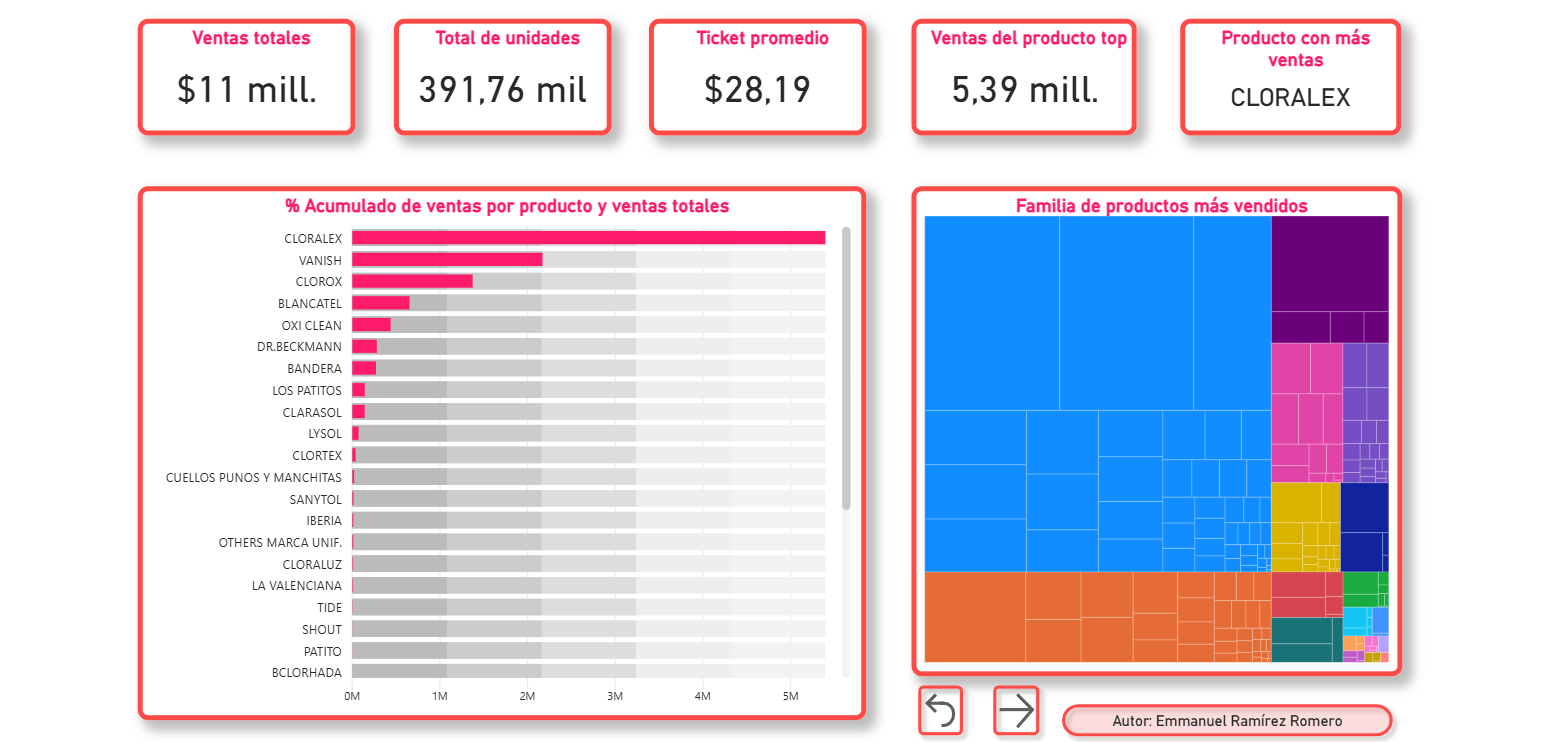

In [80]:
print("-------------------------------------------------------------------------------------------------------------------")
print("\n Menú principal")
print("-------------------------------------------------------------------------------------------------------------------")
display(Image("hoja1_menu.png", width=800))
print("-------------------------------------------------------------------------------------------------------------------")
print("\n Ventas totales")
print("-------------------------------------------------------------------------------------------------------------------")
display(Image("hoja2_ventas.png", width=800))
print("-------------------------------------------------------------------------------------------------------------------")
print("\n Ventas por Región")
print("-------------------------------------------------------------------------------------------------------------------")
display(Image("hoja3_regiones.png", width=800))
print("-------------------------------------------------------------------------------------------------------------------")
print("\n Ventas por Producto")
print("-------------------------------------------------------------------------------------------------------------------")
display(Image("hoja4_productos.png", width=800))

**Enlace al Dashboard:** [Ver Dashboard en Power BI](https://app.powerbi.com/links/VBncKRG5cc?ctid=d5af162b-2ff5-41fa-93ff-cca4b92606e9&pbi_source=linkShare)

**Enlace alternativo:** [Ver Dashboard en Power BI](https://app.powerbi.com/groups/me/reports/fd37bfc7-2049-4c44-b8ef-a74e0061a023?ctid=d5af162b-2ff5-41fa-93ff-cca4b92606e9&pbi_source=linkShare&bookmarkGuid=49fff722-8ad4-4d39-83a1-b3110af17dfc)

# 7. Predicción de Ventas con Machine Learning

### Objetivo:
- Selección y justificación del modelo
- Validación del modelo
- predicciones futuras

## Tratamiento inicial de los datos

In [36]:
# Convertir columna DATE a formato datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [37]:
# Filtrar marcas Vanish y Lysol
df_key = df[df['BRAND'].isin(['VANISH', 'LYSOL'])]

In [38]:
# Agrupar ventas por semana
df_grouped = df_key.groupby(['DATE','BRAND'])['TOTAL_SALES'].sum().reset_index()

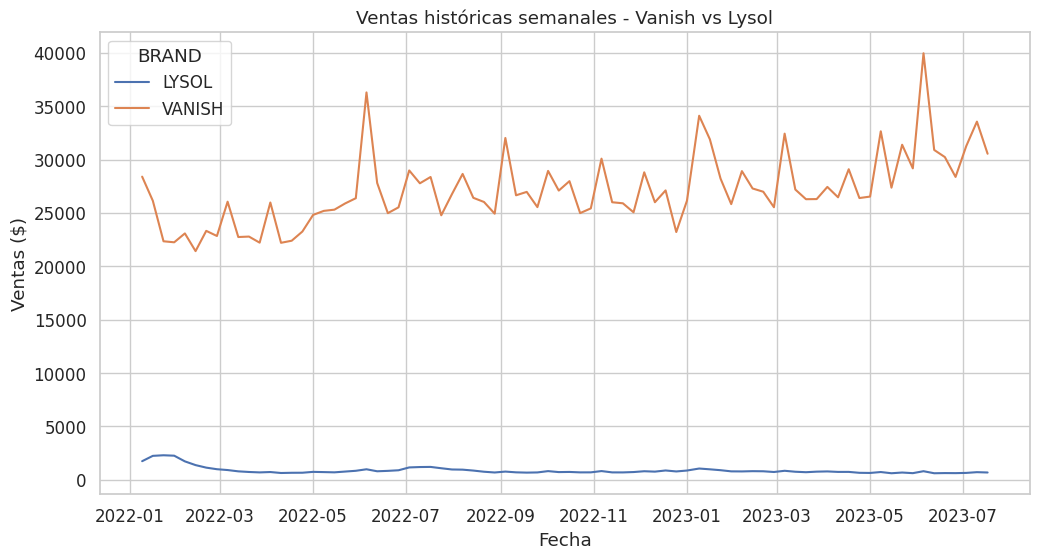

In [39]:
# Visualización inicial
plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x="DATE", y="TOTAL_SALES", hue="BRAND")
plt.title("Ventas históricas semanales - Vanish vs Lysol")
plt.xlabel("Fecha")
plt.ylabel("Ventas ($)")
plt.show()

## Revisión de estacionariedad (Dickey-Fuller)

In [40]:
from statsmodels.tsa.stattools import adfuller

# Separar Vanish y Lysol
df_vanish = df_grouped[df_grouped['BRAND']=='VANISH'].set_index('DATE')
df_lysol = df_grouped[df_grouped['BRAND']=='LYSOL'].set_index('DATE')

# Prueba de estacionariedad
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    print(f'Prueba ADF para {title}')
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> La serie es estacionaria.\n")
    else:
        print("=> La serie NO es estacionaria.\n")

# Ejecutar pruebas
adf_test(df_vanish['TOTAL_SALES'], 'Vanish')
adf_test(df_lysol['TOTAL_SALES'], 'Lysol')

Prueba ADF para Vanish

ADF Statistic     -0.790757
p-value            0.821822
# Lags Used       12.000000
# Observations    67.000000

=> La serie NO es estacionaria.

Prueba ADF para Lysol

ADF Statistic     -2.634485
p-value            0.086077
# Lags Used        0.000000
# Observations    79.000000

=> La serie NO es estacionaria.

El análisis preliminar reveló que las series presentan dependencia temporal y tendencias que no pueden ser explicadas únicamente por variables externas, lo que hace que un modelo de regresión múltiple sea inapropiado en este contexto. La prueba de Dickey-Fuller se aplicó a cada serie para evaluar su estacionariedad; los resultados indicaron que las series no eran estacionarias, justificando la inclusión de un término de diferenciación en el modelo ARIMA.

## ARIMA para Vanish y Lysol

In [86]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.26.4 pmdarima==2.0.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


### Comparativa de predicciones contra datos reales

Vanish - ARIMA(0, 1, 2) -> RMSE: 4948.51, MAE: 3789.12

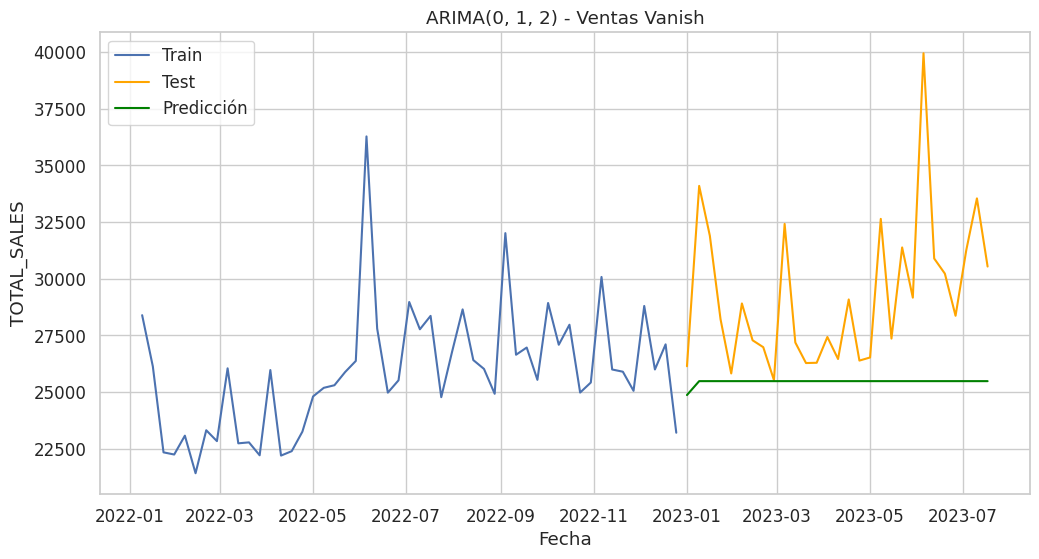

Lysol - ARIMA(1, 1, 0) -> RMSE: 110.54, MAE: 84.43

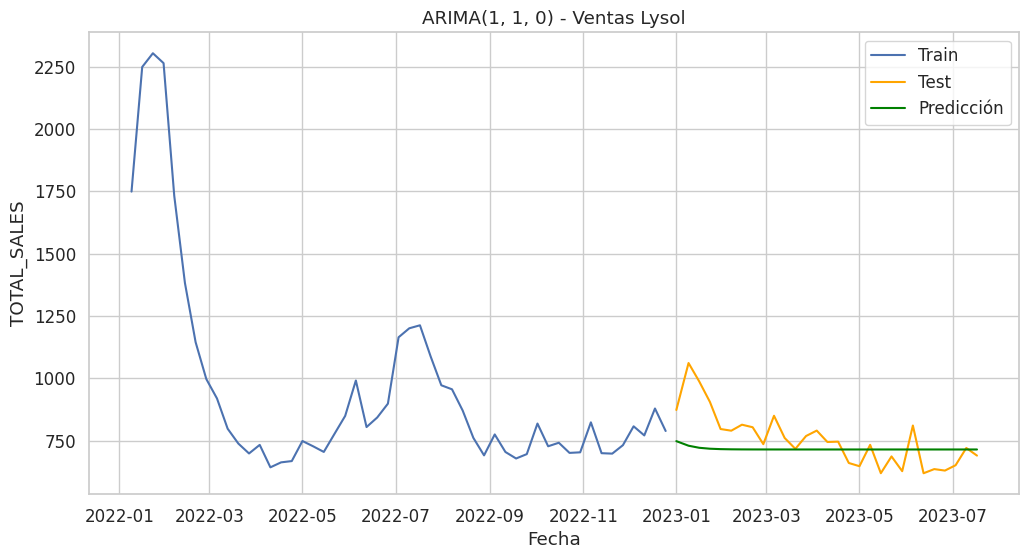

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Función para entrenar y predecir ---
def arima_forecast(df_brand, brand_name, split_date="2023-01-01"):
    # División temporal
    train = df_brand.loc[df_brand.index < split_date]
    test = df_brand.loc[df_brand.index >= split_date]

    # Ajuste con auto_arima para mejores parámetros
    stepwise_fit = auto_arima(
        train['TOTAL_SALES'],
        start_p=1, start_q=1,
        max_p=5, max_q=5,
        d=None,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    best_order = stepwise_fit.order

    # Entrenar ARIMA con parámetros óptimos
    model = ARIMA(train['TOTAL_SALES'], order=best_order)
    model_fit = model.fit()

    # Predicción sobre test
    pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ="levels")
    pred.index = test.index  # Reindexar para evitar errores y gráficos extraños

    # Métricas
    rmse = np.sqrt(mean_squared_error(test['TOTAL_SALES'], pred))
    mae = mean_absolute_error(test['TOTAL_SALES'], pred)
    print(f"{brand_name} - ARIMA{best_order} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Gráfico comparativo
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train['TOTAL_SALES'], label="Train")
    plt.plot(test.index, test['TOTAL_SALES'], label="Test", color="orange")
    plt.plot(pred.index, pred, label="Predicción", color="green")
    plt.title(f"ARIMA{best_order} - Ventas {brand_name}")
    plt.xlabel("Fecha")
    plt.ylabel("TOTAL_SALES")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model_fit, pred, train, test

# --- Ejecutar para Vanish ---
results_vanish, pred_vanish, train_vanish, test_vanish = arima_forecast(df_vanish, "Vanish")

# --- Ejecutar para Lysol ---
results_lysol, pred_lysol, train_lysol, test_lysol = arima_forecast(df_lysol, "Lysol")

**Interpretación de estos resultados:**

**Para Vanish:**
Dada la naturaleza de los datos, se usó un modelo ARIMA sin estacionalidad para poder realizar el proceso, eso quiere decir que el modelo captura la tendencia general y promedia la serie, por lo cual se obtiene esa línea recta en las predicciones. Esto no significa que el modelo no funcione, sino que el nivel de volatilidad de la serie supera la capacidad de un modelo ARIMA básico.

**Para Lysol:**
* La serie es estable con menor variabilidad.
* La predicción sigue muy de cerca la media histórica.
* Los picos ocasionales se suavizan, reflejando la tendencia central

**Conclusión general**

Se seleccionó un modelo de series de tiempo ARIMA para predecir las ventas de Vanish y Lysol, basándose en la observación de patrones temporales y la confirmación de no estacionariedad mediante la prueba de Dickey-Fuller. Para optimizar el modelo, se empleó la función auto_arima, la cual explora automáticamente combinaciones de los parámetros (p,d,q) y selecciona aquel conjunto que minimiza el criterio de información Akaike (AIC). Este procedimiento asegura que el modelo final capture de la mejor manera posible la dinámica de la serie histórica, evitando tanto el sobreajuste como la subestimación de la variabilidad de las ventas.

In [42]:
# Número de semanas a predecir
n_weeks = 12

# --- Predicciones futuras Vanish ---
future_index_vanish = pd.date_range(start=test_vanish.index[-1] + pd.Timedelta(weeks=1), periods=n_weeks, freq='W-SUN')
future_forecast_vanish = results_vanish.get_forecast(steps=n_weeks).predicted_mean
future_forecast_vanish.index = future_index_vanish

# --- Predicciones futuras Lysol ---
future_index_lysol = pd.date_range(start=test_lysol.index[-1] + pd.Timedelta(weeks=1), periods=n_weeks, freq='W-SUN')
future_forecast_lysol = results_lysol.get_forecast(steps=n_weeks).predicted_mean
future_forecast_lysol.index = future_index_lysol

# --- Crear DataFrame comparativo ---
future_table = pd.DataFrame({
    'Semana': range(1, n_weeks+1),
    'Fecha Vanish': future_forecast_vanish.index,
    'Predicción Vanish': future_forecast_vanish.values,
    'Fecha Lysol': future_forecast_lysol.index,
    'Predicción Lysol': future_forecast_lysol.values
})

# Mostrar tabla
future_table

,Semana,Fecha Vanish,Predicción Vanish,Fecha Lysol,Predicción Lysol
0,1,2023-07-30,24871.819711,2023-07-30,747.938243
1,2,2023-08-06,25485.224857,2023-08-06,729.586806
2,3,2023-08-13,25485.224857,2023-08-13,721.309943
3,4,2023-08-20,25485.224857,2023-08-20,717.576913
4,5,2023-08-27,25485.224857,2023-08-27,715.893243
5,6,2023-09-03,25485.224857,2023-09-03,715.133874
6,7,2023-09-10,25485.224857,2023-09-10,714.791384
7,8,2023-09-17,25485.224857,2023-09-17,714.636914
8,9,2023-09-24,25485.224857,2023-09-24,714.567245
9,10,2023-10-01,25485.224857,2023-10-01,714.535823


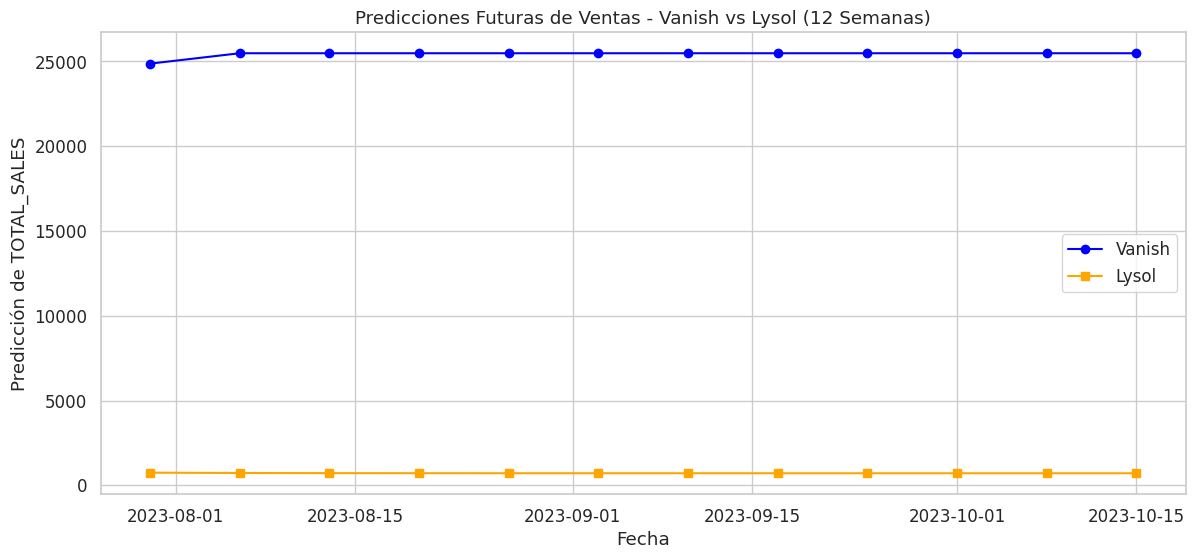

In [43]:
plt.figure(figsize=(14,6))
plt.plot(future_forecast_vanish.index, future_forecast_vanish, label="Vanish", marker='o', color='blue')
plt.plot(future_forecast_lysol.index, future_forecast_lysol, label="Lysol", marker='s', color='orange')
plt.title("Predicciones Futuras de Ventas - Vanish vs Lysol (12 Semanas)")
plt.xlabel("Fecha")
plt.ylabel("Predicción de TOTAL_SALES")
plt.legend()
plt.grid(True)
plt.show()

Las predicciones futuras muestran un comportamiento estable para ambos productos durante las próximas 12 semanas. Para Vanish, el modelo proyecta ventas relativamente constantes, ligeramente por debajo de los valores históricos recientes, lo que refleja la tendencia lineal observada en el período de prueba. Por su parte, Lysol mantiene también un nivel de ventas estable, con valores más bajos en comparación con Vanish, reflejando la menor magnitud de sus ventas históricas. Estas proyecciones permiten a los equipos de planificación anticipar niveles de inventario y ajustar estrategias comerciales sin introducir expectativas erróneas de picos de demanda abruptos, aunque se debe tener en cuenta que los modelos actuales no capturan variaciones repentinas que puedan surgir en el mercado.

# 8. Conclusiones y Recomendaciones




## Resumen de los hallazgos clave
A lo largo del análisis de datos de ventas de Reckitt, se identificó que una región domina el volumen de ventas totales, mientras que ciertos productos muestran un rendimiento significativamente superior respecto al resto. La segmentación mediante clustering permitió identificar grupos de productos con características similares en términos de ventas y segmentos de mercado, lo que facilita la priorización de estrategias de marketing y distribución. Además, las tendencias mensuales reflejan patrones estacionales que podrían ser aprovechados para ajustar la producción y los inventarios.

Las predicciones futuras del modelo ARIMA muestran un comportamiento estable para ambos productos durante las próximas 12 semanas. Para Vanish, el modelo proyecta ventas relativamente constantes, ligeramente por debajo de los valores históricos recientes, lo que refleja la tendencia lineal observada en el período de prueba. Por su parte, Lysol mantiene también un nivel de ventas estable, con valores más bajos en comparación con Vanish, reflejando la menor magnitud de sus ventas históricas. Estas proyecciones permiten a los equipos de planificación anticipar niveles de inventario y ajustar estrategias comerciales sin introducir expectativas erróneas de picos de demanda abruptos, aunque se debe tener en cuenta que los modelos actuales no capturan variaciones repentinas que puedan surgir en el mercado.

## Impacto del análisis en la estrategia empresarial
Los insights obtenidos proporcionan información que le facilita a la empresa la toma de decisiones estratégicas. La compañía puede enfocar sus recursos en las regiones y productos de mayor desempeño, optimizar la planificación de inventario, y ajustar campañas de promoción de manera más precisa. La predicción de ventas mediante modelos de regresión y series de tiempo ofrece una proyección confiable que permite anticipar la demanda y reducir riesgos de sobrestock o desabastecimiento.

## Recomendaciones
Se sugiere reforzar las acciones comerciales en las regiones de mayor potencial y explorar oportunidades de crecimiento en aquellas con ventas menores. Asimismo, es recomendable utilizar los clusters de productos para diseñar campañas segmentadas, priorizar lanzamientos de nuevos productos en mercados estratégicos, y optimizar la logística según el patrón de demanda proyectado.  

## Futuras mejoras
Para continuar mejorando el análisis, se podrían integrar más variables externas como datos de competencia, tendencias de mercado o indicadores socioeconómicos que permitan enriquecer los modelos predictivos; además, tener la información regional empatada con las zonas geográficas en las que se distribuyen los productos ayudaría a generar estrategias tanto a nivel logístico, socioeconómico y de densidad poblacional para una mejor distribución y marketing de los productos. También sería útil implementar dashboards interactivos que se actualicen en tiempo real, y evaluar modelos de machine learning más avanzados para mejorar la precisión de las predicciones de ventas y segmentaciones.